<a href="https://colab.research.google.com/github/TomMaullin/BLMM-sandbox/blob/master/FS_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FS implementation in python

This code implements the Fisher Scoring algorithm for estimating the parameters of linear mixed effects models as described in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579).

## Pip Installations

Pip install everything.

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install sparse
!pip install nibabel
!pip install nilearn


## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for sparse matrix functions.
 - `pandas` for quick reading and writing of csv files.
 - `os` and `sys` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays.

In [2]:
import numpy as np
import cvxopt
import pandas as pd
import os
import time
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sys
import nibabel as nib
import nilearn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [0]:
# Import shutil and remove old testdata
#import shutil
#shutil.rmtree('/Data')

# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  


### Z matrix

The below reads in Z and makes an image of Z transpose.


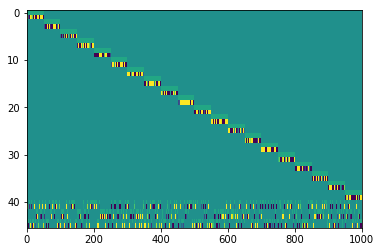

In [4]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/Z_3col_1factor.csv',header=None).values#
Z = scipy.sparse.csr_matrix((Z_3col[:,2].tolist(), \
                            ((Z_3col[:,0]-1).astype(np.int64), \
                             (Z_3col[:,1]-1).astype(np.int64))))

# Create an image of Z'
imshow(Z.toarray().transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

# Number of subjects
n = Z.shape[0]

#### Dealing with ill-specified intercept models

The above Random effects design matrix has multiple intercepts and is therefore of less than rank $q$; to resolve this we transform $Z$ by a matrix $c$ such that it's now has ($q-\sum_{i=1}^r\mathbb{1_{[\text{Factor i has an intercept}]}}$) orthogonal columns (where $\mathbb{1}$ is an indicator function). This is achieved in the below code by having $c$ as the unique matrix which subtracts, for each factor, the intercept for the last level of the factor away from the other levels of said factor. This may be clearer to understand in matrix format:

Example:

$$\begin{bmatrix} z_1 & 0 & 0 \\ z_2 & 0 & 0 \\ z_3 & 0 & 0 \\0 & z_4 & 0 \\ 0 & z_5 & 0 \\ 0 & z_6 & 0 \\ 0 & 0 & z_7 \\ 0 & 0 & z_8 \\ 0 & 0 & z_9 \\ \end{bmatrix} c = \begin{bmatrix} z_1 & 0 \\ z_2 & 0 \\ z_3 & 0 \\0 & z_4 \\ 0 & z_5 \\ 0 & z_6 \\ -z_7 & -z_7 \\ -z_8 & -z_8  \\ -z_9 & -z_9  \\ \end{bmatrix}$$

In this example, $c$ would be given by the matrix:

$$c = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ -1 & -1\end{bmatrix}$$

In this code I have made the assumption WLOG that the intercept for each factor, should it be included, is the first parameter listed for each factor.

UPDATE: SCRAPPED - RUINED BLOCK DIAGONAL STRUCTURE OF Z

In [0]:
#import numba

#@numba.jit
#def obtainC(nlevels, nparams, interceptIndicator):
  
  # Columns per factor
  # This array tells us how many columns each factor has in Z.
  # i.e. colsPerFactor[k]=4 means the kth factor has 4 columns
#  colsPerFactor = nlevels*nparams
  
  # List of first column of Z for each level of each factor (If an intercept has
  # been included for factor k, then it is assumed that the intercept is in the 
  # first column of each level of factor k; therefore this list contains all 
  # intercept column indices by assumption). One additional entry is included at 
  # the end which is the number of columns in z; this can be useful looping.
#  interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)

  # The below array marks the first entry for each factor in interceptCols
  # i.e. interceptCols[factorChangepoints[k]] is the first intercept for
  # factor k
#  factorChangepoints = np.insert(np.cumsum(nlevels),0,0)

  # Loop through each factor
#  for k in np.arange(len(nlevels)):
  
    # If we have an intercept for this factor work out which
    # columns hold the intercepts
#    if interceptIndicator[k]==1:
      
      # Get the intercept columns for factor k
#      interceptCols_k = interceptCols[factorChangepoints[k]:factorChangepoints[k+1]]-interceptCols[factorChangepoints[k]]
      
      # Get a vector with -1 in each position for all intercept columns
#      negativeCols = np.zeros(colsPerFactor[k])
#      negativeCols[interceptCols_k] = -1
      
      # Get an identity matrix which is number of columns for factor k by number
      # of columns for factor k in size. This will become c for factor k
#      c_k = np.eye(colsPerFactor[k])
      
      # This is the index of the column we are removing from Z with this transform
#      toRemove = interceptCols_k[-1]
      
      # Place the negative Cols matrix in the row corresponding to the intercept 
      # column
#      c_k[toRemove,:] = negativeCols
#      c_k = np.delete(c_k,toRemove,axis=1)
      
#      if k == 0:
        
#        c = c_k
        
#      else:
        
#        c = scipy.linalg.block_diag(c, c_k)
      
#  imshow(c, \
#     interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
#  plt.colorbar()

#  return(c)

#t1 = time.time()
#c=obtainC(nlevels, nparams, [1,1])      
#t2 = time.time()
#print(t2-t1)

#t1 = time.time()
#obtainC(nlevels, nparams, [1,1])      
#t2 = time.time()
#print(t2-t1)


#print(np.cumsum(nlevels * nparams))

#nparams = [2,2]
#nparamstmp[1] = 3

# List of columns of Z containing intercept
#interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)[:-1]

# The below array marks the first entry for each factor in interceptCols
# i.e. interceptCols[factorChangepoints[k]] is the first intercept for
# factor k
#factorChangepoints = np.insert(np.cumsum(nlevels),0,0)
#print('factor change points')
#print(factorChangepoints)

# Columns per factor
# This array tells us how many columns each factor has in Z.
# i.e. colsPerFactor[k]=4 means the kth factor has 4 columns
#colsPerFactor = nlevels*nparams
#print('colsPerFactor')
#print(colsPerFactor)

#k = 0
# Intercept columns for one factor
#print(interceptCols[factorChangepoints[k]:factorChangepoints[k+1]])

#print(interceptCols)
#print(len(interceptCols))

#print(Z[:, interceptCols].toarray())

#print(np.cumsum(nlevels))

#print(nparams)
      
  

In [0]:

#imshow((Z @ scipy.sparse.csr_matrix(c)).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()


In [0]:

#imshow(((Z @ scipy.sparse.csr_matrix(c)).transpose() @ (Z @ scipy.sparse.csr_matrix(c))).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()

In [0]:
#imshow((Z).toarray(), \
#     interpolation='nearest', aspect='auto', vmax = 2, vmin = -1)
#plt.colorbar()

In [0]:
#imshow((Z.transpose() @ Z).toarray(), \
#     interpolation='nearest', aspect='auto')
#plt.colorbar()

#### Demean and rescale Z

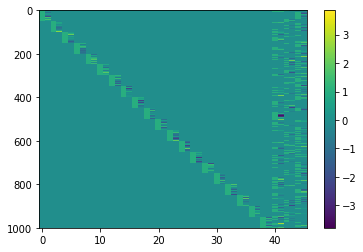

In [8]:
def demeanAndRescaleZ(Z, nparams, nlevels):
  
  # List of columns of Z containing intercept, assume if there is an intercept;
  # that it is in the first column of each level of each factor
  interceptCols = np.insert(np.cumsum(np.repeat(nparams, nlevels)),0,0)[:-1]
  
  # Make demeaned and rescaled Z
  Z_dr = Z
  
  # Loop through each column
  for i in np.arange(Z.shape[1]):
    
    # Check if column is an intercept
    if i in interceptCols:
      
      # If the array doesn't contain only zero and one
      if not np.array_equal(np.unique(Z[:,i]), np.array([0,1])):
        
        Z_dr[np.nonzero(Z_dr[:,i]),i] = (Z_dr[np.nonzero(Z_dr[:,i]),i]-np.mean(Z_dr[np.nonzero(Z_dr[:,i]),i]))/np.std(Z_dr[np.nonzero(Z_dr[:,i]),i])
                                         
    else:
      
      Z_dr[np.nonzero(Z_dr[:,i]),i] = (Z_dr[np.nonzero(Z_dr[:,i]),i]-np.mean(Z_dr[np.nonzero(Z_dr[:,i]),i]))/np.std(Z_dr[np.nonzero(Z_dr[:,i]),i])
        
  return(Z_dr)
nlevels = np.array([20,3])#])#
nparams = np.array([2,2])#])#
Z_dr = demeanAndRescaleZ(Z.toarray(), nparams, nlevels)

imshow(Z_dr, \
     interpolation='nearest', aspect='auto')
plt.colorbar()


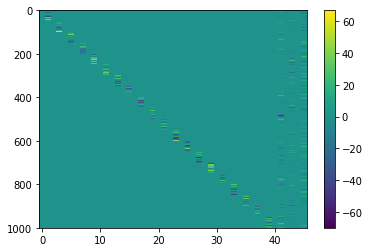

In [9]:
imshow(Z.toarray(), \
     interpolation='nearest', aspect='auto')
plt.colorbar()

#Z_orig = Z.toarray()
#Z = scipy.sparse.csr_matrix(Z_dr)

### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst = pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/estd_rfxvar_1factor.csv',header=None).values#

### Y vector

The response vector is read in here:

In [0]:
Y=pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/Y_1factor.csv',header=None).values#

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


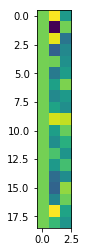

In [12]:
X=pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/X_1factor.csv',header=None).values#

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])#])#
nparams = np.array([2,2])#])#

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/true_b_1factor.csv',header=None).values#

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values#pd.read_csv('/Data/BLMM-testdata/true_beta_1factor.csv',header=None).values#

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. 

In [16]:
# Z transpose Z
print(Z.shape)
ZtZ = np.matmul(Z.toarray().transpose(),Z.toarray()) # This works for products involving sparse
# Sparse 
# ZtZ = Z.transpose() * Z

# Z transpose X
XtZ = np.matmul(X.transpose(),Z.toarray())

# X transpose Z
ZtX = np.matmul(Z.toarray().transpose(),X)

# ZtY
ZtY = np.matmul(Z.toarray().transpose(),Y)

# YtZ
YtZ = np.matmul(Y.transpose(),Z.toarray())

# XtX
XtX = np.matmul(X.transpose(),X)

# XtY
XtY = np.matmul(X.transpose(),Y)

# YtX
YtX = np.matmul(Y.transpose(),X)

# YtX
YtY = np.matmul(Y.transpose(),Y)

(1000, 46)


## Helper Functions

This section contains miscellaneous functions used to help the `FS` function including functions to work out the duplication matrix.


###Matrix to Vector function

This function takes in a matrix and vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ d \\ g \\ b \\ e \\ h \\ c \\ f \\ i \end{bmatrix}$$.

In [17]:
def mat2vec(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose().reshape(matrix.shape[0]*matrix.shape[1],1))

# Example:
matrix = np.random.randn(3,3)
print(matrix)
print(mat2vec(matrix))

[[ 0.70105957  1.53122018 -1.61626081]
 [-0.56557918 -0.27036032 -1.01789735]
 [ 0.42650756  1.59044263 -0.4313635 ]]
[[ 0.70105957]
 [-0.56557918]
 [ 0.42650756]
 [ 1.53122018]
 [-0.27036032]
 [ 1.59044263]
 [-1.61626081]
 [-1.01789735]
 [-0.4313635 ]]


###Matrix to Vector function

This function takes in a (symmetric, square) matrix and half-vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix, below and including the diagonal, stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ b & d & e \\ c & e & f \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}$$.

In [18]:
def mat2vech(matrix):
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0]) #Try mat.transpose()[trilu]?
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(np.array([matrix[rowinds[perm],colinds[perm]]]).transpose())

# Example:
matrix = np.random.randn(3,3)
print(matrix*matrix.transpose())
print(mat2vech(matrix*matrix.transpose()))

#print(vech2mat(invDupMat(3) @ mat2vec(matrix*matrix.transpose())))

[[ 4.11709191 -0.0507718   0.05208841]
 [-0.0507718   0.63279883 -1.18873472]
 [ 0.05208841 -1.18873472  1.58103632]]
[[ 4.11709191]
 [-0.0507718 ]
 [ 0.05208841]
 [ 0.63279883]
 [-1.18873472]
 [ 1.58103632]]


In [0]:
def vec2mat(vec):
  
  # Return matrix
  return(vec.reshape(np.int64(np.sqrt(vec.shape[0])),np.int64(np.sqrt(vec.shape[0]))).transpose())

# Example
#vec = np.array([[1,2,3,4]]).transpose()
#mat = vec2mat(vec)
#print(vec)
#print(mat)

In [0]:
def vech2mat(vech):
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[0]))/2)
  matrix = np.zeros((n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0])
  
  # Assign values to upper half
  matrix[colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0])
  
  # Return vectorised half-matrix
  return(matrix)

# Example:
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#matrix = vech2mat(vech)
#print(vech)
#print(matrix)

In [0]:
def vec2vech(vec):
  
  # Return vech
  return(mat2vech(vec2mat(vec)))

# Example
#vec = np.array([[1],[2],[3],[2],[4],[5],[3],[5],[6]])
#vech = vec2vech(vec)

#print(vec)
#print(vech)

In [0]:
def vech2vec(vech):
  
  # Return vec
  return(mat2vec(vech2mat(vech)))

# Example
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#vec = vech2vec(vech)

#print(vech)
#print(vec)

In [0]:
def dupMat(n):
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = vech2vec(vech)
  
  # Make D (sparse one hot encoded vec)
  D = scipy.sparse.csr_matrix((np.ones(n**2),(np.arange(n**2),np.int64(vec).reshape(vec.shape[0]))))
  
  return(D)

# Example
#print(dupMat(3))

In [24]:
def invDupMat(n):
  
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = np.int64(vech2vec(vech))
  vec = vec.reshape(vec.shape[0])
  
  # Work out frequency of each entry
  freq = 1/np.bincount(vec)
  
  # Work out duplication matrix
  D = scipy.sparse.csr_matrix((freq[vec],(vec,np.arange(n**2))))
  
  return(D)

# Example
print(invDupMat(3))

  (0, 0)	1.0
  (1, 1)	0.5
  (1, 3)	0.5
  (2, 2)	0.5
  (2, 6)	0.5
  (3, 4)	1.0
  (4, 5)	0.5
  (4, 7)	0.5
  (5, 8)	1.0


In [0]:
def blockInverse(matrix, blockSize, numBlocks):

  invMatrix = scipy.sparse.csr_matrix((np.array([]), (np.array([]),np.array([]))),shape=matrix.shape)
  
  # For each level, invert the corresponding block on the diagonal
  for i in range(numBlocks):
    
    # The block is nparams by nparams
    blockInds = np.ix_(np.arange(i*blockSize,(i+1)*blockSize),np.arange(i*blockSize,(i+1)*blockSize))
    
    # Get the block
    block = matrix[blockInds]
    
    # Replace it with it's inverse
    invMatrix[blockInds]=scipy.sparse.linalg.inv(block)
    
  return(invMatrix)

# Example - need to have loaded in data first

# Get ZtZ just for the first grouping factor
firstFactorIndices = np.ix_(np.arange(nlevels[0]*nparams[0]),np.arange(nlevels[0]*nparams[0]))
ZtZ_f1 = ZtZ[firstFactorIndices]

# Compute the block inverse for ZtZ_f1
#t1 = time.time()
#ZtZ_f1_inv = blockInverse(matrix=ZtZ_f1, blockSize=nparams[0], numBlocks=nlevels[0])
#t2 = time.time()
#blockInverse_time = t2-t1

# Compare it to the inverse scipy would calculate
#t1 = time.time()
#ZtZ_f1_inv_sp = scipy.sparse.linalg.inv(ZtZ_f1)
#t2 = time.time()
#scipyInverse_time = t2-t1

#print(blockInverse_time)
#print(scipyInverse_time)


In [26]:
def recursiveInverse(M, nparams, nlevels):
  
  # Check if we have a matrix we can partition into more than 1 block
  if len(nparams) > 1:
  
    # Work out qc
    qc = nparams[-1]*nlevels[-1]
    # Make q
    q = M.shape[0]

    # Get A, B and C where M=[[A,B],[B',C]]
    # A
    A_inds = np.ix_(np.arange(0,(q-qc)),np.arange(0,(q-qc)))
    A = M[A_inds]

    # B
    B_inds = np.ix_(np.arange(0,(q-qc)),np.arange((q-qc),q))
    B = M[B_inds].toarray() # B is dense

    # C
    C_inds = np.ix_(np.arange((q-qc),q),np.arange((q-qc),q))
    C = M[C_inds].toarray() # C is small and now only involved in dense mutliplys

    # Recursive inverse A
    if nparams[:-1].shape[0] > 1:

      Ainv = recursiveInverse(A, nparams[:-1], nlevels[:-1]).toarray()

    else:

      #Ainv = blockInverse(A, nparams[0], nlevels[0]) - much slower
      Ainv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(A)).toarray()

    # Schur complement
    S = C-np.matmul(np.matmul(B.transpose(),Ainv),B)
    Sinv = np.linalg.inv(S)

    # Top Left Hand Side of inverse
    TLHS = Ainv + np.matmul(np.matmul(np.matmul(np.matmul(Ainv,B),Sinv),B.transpose()),Ainv)


    # Top Right Hand Side of inverse
    TRHS = -np.matmul(np.matmul(Ainv,B),Sinv)


    # Bottom Right Hand Side of inverse
    BRHS = Sinv

    # Join together
    top = np.hstack((TLHS,TRHS))
    bottom = np.hstack((TRHS.transpose(), BRHS))

    # Make Minv
    Minv = np.vstack((top, bottom))
    
  else:
    
    # If we have only one block; invert it
    Minv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(M)).toarray() 
  
  return(Minv)

# Example
t1 = time.time()
ZtZinv_rec = recursiveInverse(scipy.sparse.csc_matrix(ZtZ), nparams, nlevels)
t2 = time.time()
inv_rec_time = t2-t1

t1 = time.time()
ZtZinv_sp = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(ZtZ))
t2 = time.time()
inv_sp_time = t2-t1

t1 = time.time()
ZtZinv_np = np.linalg.inv(ZtZ)
t2 = time.time()
inv_np_time = t2-t1


print('Distance (norm) from identity (scipy)')
print(np.linalg.norm(np.matmul(ZtZinv_sp.toarray(),ZtZ)-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (numpy)')
print(np.linalg.norm(np.matmul(ZtZinv_np,ZtZ)-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (rec)')
print(np.linalg.norm(np.matmul(ZtZinv_rec,ZtZ)-np.eye(ZtZ.shape[0])))

print(inv_sp_time)
print(inv_np_time)
print(inv_rec_time)


Distance (norm) from identity (scipy)
289.8902619901572
Distance (norm) from identity (numpy)
1955.403906774292
Distance (norm) from identity (rec)
381.4130003726553
0.01392817497253418
0.0003743171691894531
0.015040397644042969


#### Force symmetric

The below function takes in a matrix $X$ and returns a symmetric matrix $X_s$ given by:

$$X_s = (X+X^T)/2$$

The effect of this is that if $X$ is expected to be symmetric but is not due to computational error, any antisymmetric errors will be resolved/reduced.

In [27]:
import numba
@numba.jit
def forceSym(x):
  
  # Force it to be symmetric
  return((x+x.transpose())/2)

#print(ZtZ-forceSym(ZtZ))

t1 = time.time()
ZtZ = forceSym(forceSym(ZtZ))
print(time.time()-t1)

t1 = time.time()
ZtZ = forceSym(forceSym(ZtZ))
print(time.time()-t1)

0.33131909370422363
6.747245788574219e-05


### Sum of square residuals

The function below calculates the sum of the square residuals, $e^Te$, using the below formula:

$$e^Te = (Y-X\beta)^T(Y-X\beta)$$ 
$$=Y^TY - 2Y^TX\beta + \beta^T X^TX \beta$$


----

This function takes the following inputs:

----

 - `YtX`: $Y$ transpose multiplied by $X$ ($Y^TX$ in the above notation).
 - `YtY`: $Y$ transpose multiplied by $Y$ ($Y^TY$ in the above notation).
 - `XtX`: $X$ transpose multiplied by $X$ ($X^TX$ in the above notation).
 - `beta`: An estimate of the parameter vector ($\beta$ in the above notation).
 
----

It returns as outputs:

----


 - `ete`: The sum of square residuals ($e^Te$ in the above notation).

In [28]:
def ssr(YtX, YtY, XtX, beta):
  
  # Return the sum of squared residuals
  return(YtY - 2*YtX @ beta + beta.transpose() @ XtX @ beta)

t1 = time.time()
ete = ssr(YtX, YtY, XtX, np.array([[1],[2],[3]]))
t2 = time.time()
print(t2-t1)


0.00023102760314941406


#### Get Factor/Level Indices

This function gives the indices of the columns of the $Z$ matrix which correspond to factor $k$ level $j$. 


----

This function takes the following inputs:

----

 - `k`: The grouping factor we need the columns of.
 - `j`: The level of the grouping factor $k$ which we are interested in.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 
----

It returns as outputs:

----

- `Ikj`: The indices of the columns of $Z$ corresponding to factor $k$ level $j$.

In [29]:
import numba

@numba.jit
# k and j are both zero indexed
def faclev_indices(k, j, nlevels, nparams):
  
  # Work out the starting point of the indices
  start = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
  
  # work out the end point of the indices
  end = start + nparams[k]
  
  return(np.arange(start, end))

t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

0.5358004570007324


In [30]:
t1 = time.time()
faclev_indices(0, 1, nlevels, nparams)
t2 = time.time()

print(t2-t1)

6.556510925292969e-05


### Initial Beta

The below function returns the OLS estimator for $\hat{\beta}$, given by:

$$\hat{\beta}_{OLS}=(X'X)^{-1}X'Y$$

----

This function takes the following inputs:

----

 - `XtX`: The design matrix transposed and multiplied by itself ($X'X$ in the above notation)
 - `XtY`: The design matrix transposed and multiplied by the response vector ($X'Y$ in the above notation).
 
----

It returns as outputs:

----

- `beta`: The OLS estimate of $\beta$ ($\hat{\beta}_{OLS}$ in the above notation).



In [31]:
def initBeta(XtX, XtY):
  
  # Get the beta estimator
  beta = np.linalg.solve(XtX,XtY)
  
  # Return the result
  return(beta)

print(initBeta(XtX,XtY))
print(np.linalg.inv(XtX) @ XtY)

[[0.1591389 ]
 [3.83124154]
 [3.14595612]]
[[0.1591389 ]
 [3.83124154]
 [3.14595612]]


#### Initial Sigma

The function below returns an initial estimate for the Fixed Effects Variance, $\sigma^2$. The estimator used is based on the suggested OLS estimator in Demidenko (2012) and is given by:

$$\hat{\sigma}^2_{OLS}=\frac{1}{n}(Y-X\beta)^T(Y-X\beta)$$
$$=\frac{1}{n}e^Te$$

----

This function takes the following inputs:

----

 - `ete`: The sum of square residuals ($e^Te$ in the above notation).
 - `n`: The total number of observations ($n$ in the above notation).
 
----

It returns as outputs:

----

- `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).

In [0]:
def initSigma2(ete, n):

  # Return the OLS estimate of sigma
  return(1/n*ete[0,0])

#### Initial D_k

The function below returns an initial estimate for the Random Effects Variance matrix for the $k^{th}$ grouping factor, $D_k$. The estimator used is an adaption of the suggested estimator in Demidenko (2012) and is given by:

$$vec(\hat{D}_{k})=\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)$$

Or:

$$\hat{D}_{k}=matrix\bigg(\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)\bigg)$$

----

This function takes the following inputs:

----

 - `k`: The grouping factor we wish to estimate $D$ for ($k$ in the above notation)
 - `lk`: The number of levels belonging to grouping factor $k$ ($l_k$ in the above notation).
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).
 
----

It returns as outputs:

----

- `Dkest`: The inital estimate of $D_k$ ($\hat{D}_k$ in the above notation).


###CHECK DERIVATION

In [33]:
def initDk(k, lk, ZtZ, Zte, sigma2):
  
  # Initalize D to zeros
  invSig2ZteetZminusZtZ = np.zeros((nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out Z_(k, j)'Z_(k, j)
    ZkjtZkj = ZtZ[np.ix_(Ikj,Ikj)]
    
    # Work out Z_(k,j)'e
    Zkjte = Zte[Ikj,:]
    
    if j==0:
      
      # Add first Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add first \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
      
    else:
      
      # Add next Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = ZtZkronZtZ + np.kron(ZkjtZkj,ZkjtZkj.transpose())
      
      # Add next \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = invSig2ZteetZminusZtZ + 1/sigma2*(Zkjte @ Zkjte.transpose()) - ZkjtZkj
  
  # Work out the final term.
  Dkest = vec2mat(np.linalg.inv(ZtZkronZtZ) @ mat2vec(invSig2ZteetZminusZtZ)) 
  
  return(Dkest)

Zte = ZtY-ZtX @ np.array([[1],[2],[3]])

t1 = time.time()
initDk(0, nlevels[0], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

t1 = time.time()
initDk(0, nlevels[0], ZtZ, Zte , 1)
t2 = time.time()

print(t2-t1)

0.006935596466064453
0.003425121307373047


#### Non-negative Definite D

The below function takes in a covariance matrix $D$ and finds nearest projection onto the space of non-negative definite matrices $\mathbb{D}_+$. It uses the following method taken from Demidenko (2012), page 105:

If $D$ is non-negative definite and has eigenvalue decomposition $D=P\Lambda P^T$ it's closest projection into $\mathbb{D}_+$ is defined by the matrix below:

$$\hat{D}_+ = P\Lambda_+P'$$

Where $\Lambda_+$ is defined by the elementwise maximum of $\Lambda$ and 0; i.e. $\Lambda_{+(i,j)} = max(\Lambda_{+(i,j)},0)$.

Note: This is not to be confused with the generalized inverse of the duplication matrix $\mathcal{D}^+$.

----

This function takes the following inputs:

----

 - `D`: A square symmetric matrix.
 
----

It returns as outputs:

----

- `D_nnd`: The nearest projection of $D$ onto the space of non-negative definite matrices $\mathbb{D}_+$.

In [0]:
def makeDnnd(D):
  
  # Check if we have negative eigenvalues
  if not np.all(np.linalg.eigvals(D)>0):
  
    # If we have negative eigenvalues
    eigvals,eigvecs = np.linalg.eigh(D)
    
    # Work out elementwise max of lambda and 0
    lamplus = np.diag(np.maximum(eigvals,0))
    
    # Work out D+
    D_nnd = eigvecs @ lamplus @ np.linalg.inv(eigvecs)
    
  else:
    
    # D is already non-negative in this case
    D_nnd = D
    
  return(D_nnd)
  

#### Log likelihood of $(\beta, \sigma^2, D)$

This function returns the log likelihood of $(\beta, \sigma^2, D)$ which is given by the below equation:

$$l(\beta,\sigma^2,D) = -\frac{1}{2}\bigg\{ n\text{ln}(\sigma^2) + \text{ln}|I+Z'ZD| + \sigma^{-2}(e'e-e'ZD(I+Z'ZD)^{-1}Z'e)\bigg\}$$


----

This function takes the following inputs:

----

 - `n`: The total number of observations.
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by Z ($Z'Z$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z'e=Z'(Y-X\beta)$ in the above notation).
 - `ete`: The OLS residuals transposed and then multiplied by themselves ($e'e=(Y-X\beta)'(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 - `D`: The random effects variance-covariance matrix ($D$ in the above notation)
 
----

It returns as outputs:

----

- `llh`: The log likelihood of $(\beta, \sigma^2, D)$ ($l(\beta,\sigma^2,D)$ in the above notation).


In [35]:
def llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D):
  
  # Work out the log likelihood
  llh = -0.5*(n*np.log(sigma2) + np.log(np.linalg.det(np.eye(ZtZ.shape[0]) + ZtZ @ D)) + (1/sigma2)*(ete - forceSym(Zte.transpose() @ DinvIplusZtZD @ Zte)))
  
  # Return result
  return(llh)

Ddict = dict()
print(RFXVar_REst)
for k in np.arange(len(nparams)):
  
  Ddict[k] = RFXVar_REst[np.ix_(np.arange(2*k,2*(k+1)),np.arange(2*k,2*(k+1)))]#makeDnnd(initDk(k, nlevels[k], ZtZ, Zte, sigma2))#
  print(Ddict[k])

# Matrix version
D = np.array([])
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = Ddict[i]

    else:

      D = scipy.linalg.block_diag(D, Ddict[i])

beta = beta_True
q = Z.shape[1]
sigma2 = 1
Zte = ZtY - ZtX @ beta
ete = ssr(YtX, YtY, XtX, beta)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)
t1 = time.time()
loglh = llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)
t2 = time.time()

print(loglh)

[[ 1.24022707  0.36034323  0.          0.        ]
 [ 0.36034323  5.0719078   0.          0.        ]
 [ 0.          0.         20.68631165 -0.79595202]
 [ 0.          0.         -0.79595202  0.21015464]]
[[1.24022707 0.36034323]
 [0.36034323 5.0719078 ]]
[[20.68631165 -0.79595202]
 [-0.79595202  0.21015464]]
[[-683.03796665]]


#### Derivative of $l$ with respect to $\beta$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \beta} = \sigma^{-2}X'(I+ZDZ')^{-1}(Y-X\beta)$$
$$ = \sigma^{-2}X'(I-ZD(I+Z'ZD)^{-1}Z')(Y-X\beta)$$
$$ = \sigma^{-2}X'(Y-X\beta)-X'ZD(I+Z'ZD)^{-1}Z'(Y-X\beta) $$
$$ = \sigma^{-2}X'e-X'ZD(I+Z'ZD)^{-1}Z'e$$

----

This function takes the following inputs:

----

 - `XtZ`: The $X$ matrix transposed and then multiplied by Z ($X^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldb`: The derivative of $l$ with respect to $\beta$.



In [36]:
def get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte):
  
  # Return the derivative
  return(1/sigma2*(Xte - (XtZ @ DinvIplusZtZD @ Zte)))

### Test example

p = X.shape[1]
beta = np.random.randn(p,1)

sigma2=1.1
D = np.array([])
q=Z.shape[1]
n=Z.shape[0]
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = initDk(i, nlevels[i], ZtZ, Zte, sigma2)

    else:

      D = scipy.linalg.block_diag(D, initDk(i, nlevels[i], ZtZ, Zte, sigma2))
      
IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

print(X.shape)

dldb1 = (sigma2)**(-1)*(X.transpose() @ np.linalg.inv(np.eye(n) + Z @ D @ Z.transpose()) @ (Y - X @ beta))

Xte = XtY- XtX @ beta

Zte = ZtY- ZtX @ beta

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

dldb2 = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)

print(dldb1)
print(dldb2)


print(dldb2-dldb1)

(1000, 3)
[[7.68865739e-01]
 [2.12518659e+03]
 [2.35592937e+03]]
[[7.68865739e-01]
 [2.12518659e+03]
 [2.35592937e+03]]
[[-1.71237802e-10]
 [ 1.40969405e-07]
 [ 1.04723767e-08]]


#### Derivative of $l$ with respect to $\sigma^2$

The below function calculates the derivative of the log likelihood with respect to $\beta$. This is given by the following equation:

$$\frac{\delta l}{\delta \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(Y-X\beta)'(I+ZDZ')^{-1}(Y-X\beta)$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I+ZDZ')^{-1}e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}e'(I-ZD(I+ZZ'D)^{-1}Z')e$$
$$  = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4}(e'e-e'ZD(I+ZZ'D)^{-1}Z'e)$$

----

This function takes the following inputs:

----

 - `n`: The number of observations.
 - `ete`: The OLS residuals transposed and then multiplied by themselvess ($e^Te=(Y-X\beta)^T(Y-X\beta)$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldsigma2`: The derivative of $l$ with respect to $\sigma^2$.

In [37]:
def get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD):
  
  # Return the bottom expression in the above derivation
  return(-n/(2*sigma2) + 1/(2*(sigma2**2))*(ete - forceSym(Zte.transpose() @ DinvIplusZtZD @ Zte)))


# Toy example - recalculate the required inputs
Zte = Z.toarray().transpose() @ (Y - X @ beta)
ete = (Y - X @ beta).transpose() @ (Y - X @ beta)
DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

# Time the code
t1 = time.time()
dldsigma2_1 = get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)


dldsigma2_2 = -n/(2*sigma2) + 1/(2*(sigma2**2))*(Y - X @ beta).transpose() @ np.linalg.inv(np.eye(n) + (Z @ D @ Z.transpose())) @ (Y - X @ beta)


ZtZ = Z.toarray().transpose() @ Z.toarray()

# Cannot test against n by n inversion as n by n inversion is extremely bad
print(np.amax(np.eye(n) - Z.toarray() @ D @ np.linalg.inv(np.eye(q) + ZtZ @ D) @ Z.toarray().transpose()-np.linalg.inv(np.eye(n) + (Z.toarray() @ D @ Z.toarray().transpose()))))

tmp1 = (Y - X @ beta).transpose() @ np.linalg.inv(np.eye(n) + (Z.toarray() @ D @ Z.toarray().transpose())) @ (Y - X @ beta)

tmp2 = (Y - X @ beta).transpose() @ (np.eye(n) - Z.toarray() @ D @ np.linalg.inv(np.eye(q) + ZtZ @ D) @ Z.toarray().transpose()) @ (Y - X @ beta)

#print(tmp1)
#print(tmp2)
print(tmp2-tmp1)

0.0003077983856201172
2.7351480260361105e-10
[[-6.68573193e-07]]


#### Derivative of $l$ with respect to $D_k$

The below function calculates the derivative of the log likelihood with respect to $D_k$, the random effects covariance matrix for factor $k$. This is given by the following equation:

$$\frac{\delta l}{\delta D_k} = \frac{1}{2}\sum_{j=1}^{l_k}(T_{(k,j)}u)(T_{(k,j)}u)'-\frac{1}{2}\sum_{j=1}^{l_k}T_{(k,j)}T_{(k,j)}'$$

Where $T_{(i,j)}=Z'_{(i,j)}(I+ZDZ')^{-\frac{1}{2}}$ and $u=\sigma^{-1}(I+ZDZ')^{-\frac{1}{2}}(Y-X\beta)\sim N(0,\mathbb{I})$.

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}ee'(I+ZDZ')^{-1}Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I+ZDZ')^{-1}Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1}Z')ee'(I-ZD(I+Z'ZD)^{-1}Z')'Z_{(k,j)} - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}(I-ZD(I+Z'ZD)^{-1})Z_{(k,j)}$$

$$= \frac{1}{2\sigma^2}\sum_{j=1}^{l_k}(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)(Z'_{(k,j)}e-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'e)' - \frac{1}{2}\sum_{j=1}^{l_k}Z'_{(k,j)}Z_{(k,j)}-Z'_{(k,j)}ZD(I+Z'ZD)^{-1}Z'Z_{(k,j)}$$

----

This function takes the following inputs:

----

 - `k`: The factor we wish to estimate the derivative of the covariance matrix of.
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `DinvIplusZtZD`: The product $D(I+Z'ZD)^{-1}$.
 
----

It returns as outputs:

----

- `dldD`: The derivative of $l$ with respect to $D_k$.

In [38]:
def get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD):

  # Initalize the derivative to zeros
  dldDk = np.zeros((nparams[k],nparams[k]))

  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Get (the kj^th columns of Z)^T multiplied by Z
    Z_kjtZ = ZtZ[Ikj,:]
    Z_kjte = Zte[Ikj,:]

    # Get the first term of the derivative
    Z_kjtVinve = Z_kjte - (Z_kjtZ @ DinvIplusZtZD @ Zte)
    firstterm = 1/sigma2 * forceSym(Z_kjtVinve @ Z_kjtVinve.transpose())
    
    # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
    Z_kjtZ_kj = ZtZ[np.ix_(Ikj,Ikj)]
    secondterm = forceSym(Z_kjtZ_kj) - forceSym(Z_kjtZ @ DinvIplusZtZD @ Z_kjtZ.transpose())
    #print('TT')
    #print(secondterm)
    
    if j == 0:
      
      # Start a running sum over j
      dldDk = firstterm - secondterm
      
    else:
    
      # Add these to the running sum
      dldDk = dldDk + firstterm - secondterm
      
    #print(j)
    #print(dldDk)

  # Halve the sum (the coefficient of a half was not included in the above)
  dldDk = forceSym(dldDk/2)

  # Store it in the dictionary
  return(dldDk)

IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

ZtZ = Z.toarray().transpose() @ Z.toarray()
Zte = Z.toarray().transpose() @ (Y - X @ beta)

k=0
sigma2=0.5
Zte = ZtY - ZtX @ beta

D = np.eye(D.shape[0])

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + ZtZ @ D)

t1 = time.time()
dldDk = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

t1 = time.time()
dldDk = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)
t2 = time.time()
print(t2-t1)

sqrtinvIplusZDZt = forceSym(scipy.linalg.sqrtm(np.eye(n) - Z @ DinvIplusZtZD @ Z.transpose()))
for j in np.arange(nlevels[k]):

  Ikj = faclev_indices(k, j, nlevels, nparams)
  
  #print(Zte[Ikj,:] - (Z[:,Ikj].transpose() @ (Y - X @ beta)))
  
  Z_kjt = Z[:,Ikj].transpose()
  Tkj = Z_kjt @ sqrtinvIplusZDZt

  u = 1/np.sqrt(sigma2)*sqrtinvIplusZDZt @ (Y - X @ beta)
  

  Tkju = Tkj @ u

  TkjuTkjut = Tkju @ Tkju.transpose()
  
  TkjTkjt = Tkj @ Tkj.transpose()

  
  if j == 0:
    
    sum1 = TkjuTkjut
    sum2 = TkjTkjt
    
  else:
    
    sum1 = sum1 + TkjuTkjut
    sum2 = sum2 + TkjTkjt
    
  
dldDk2 = 0.5*(sum1-sum2)
print(dldDk2)
print(dldDk)
print(dldDk-dldDk2)

0.0024018287658691406
0.00263214111328125
[[17.14865514-1.87009500e-15j  8.61485578+3.04352884e-15j]
 [ 8.61485578+3.04352884e-15j 91.80894228+3.37081270e-14j]]
[[17.14865514  8.61485578]
 [ 8.61485578 91.80894228]]
[[ 4.85300689e-12+1.87009500e-15j -7.93640709e-11-3.04352884e-15j]
 [-7.93640709e-11-3.04352884e-15j -4.37694325e-10-3.37081270e-14j]]


#### Covariance of $\frac{\delta l}{\delta \beta}$ 

The below function calculates the covariance between the derivative of the log likelihood with respect to $\beta$, given by the below formula:

$$\text{cov}\bigg(\frac{\delta l(\theta | y)}{\delta \beta}\bigg) = \sigma^{-2} X'(I+ZDZ')^{-1}X$$
$$= \sigma^{-2} X'(I-ZD(I+Z'ZD)^{-1}Z')X$$
$$= \sigma^{-2} (X'X-X'ZD(I+Z'ZD)^{-1}Z'X)$$




----

This function takes the following inputs:

----

 - `XtZ`: $X$ transpose multiplied by $Z$.
 - `XtX`: $X$ transpose multiplied by $X$.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 
----

It returns as outputs:

----

- `covdldbeta`: The covariance of the derivative of the log likelihood with respect to $\beta$.

In [39]:
def get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2):
  
  # Return the covariance of the derivative
  return((1/sigma2)*(XtX - forceSym(XtZ @ DinvIplusZtZD @ XtZ.transpose())))

## test

IplusZtZD = np.eye(q) + ZtZ @ D
DinvIplusZtZD = D @ np.linalg.inv(IplusZtZD)

t1 = time.time()
covdldbeta_1 = get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)
t2 = time.time()
print(t2-t1)


covdldbeta_2 = sigma2**(-1) * (X.transpose() @ np.linalg.inv(np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()) @ X)

#print(covdldbeta_1)
#print(covdldbeta_2)

# Inverting the n by n is (perhaps obviously) awful though... this was just a
# rough check... see below how far out from the identity the inversion mutliplied
# by the original matrix is
#print(np.linalg.inv(np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()) @ (np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()))

#print(np.linalg.inv(IplusZtZD) @ IplusZtZD)
#print(D)
print('solve vs inv')
#print((np.linalg.solve(IplusZtZD, D) @ IplusZtZD)-D)
#print(DinvIplusZtZD)
#print(np.linalg.solve(IplusZtZD, D)-DinvIplusZtZD)

0.00014543533325195312
solve vs inv


#### Covariance of $\frac{\delta l}{\delta \text{vech}(D_{k})}$ and $\frac{\delta l}{\delta \sigma^2}$

The below function calculates the covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k})$ and the derivative with respect to $\sigma^2$.


----

This function takes the following inputs:

----

 - `k`: The number of the first factor ($k$ in the above notation).
 - `sigma2`: The fixed effects variance ($\sigma^2$ in the above notation).
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `invDupMatdict`: A dictionary of inverse duplication matrices such that `invDupMatdict[k]` = $\mathcal{D}_k^+$.
 
----

It returns as outputs:

----

- `covdldDdldsigma2`: The covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\sigma^2$.


In [40]:
def get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_(k, j) over j
  RkSum = np.zeros(nparams[k],nparams[k])

  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out R_(k, j)
    Rkj = ZtZ[np.ix_(Ikj,Ikj)] - forceSym(ZtZ[Ikj,:] @ DinvIplusZtZD @ ZtZ[:,Ikj])

    # Add together
    RkSum = RkSum + Rkj

  # Multiply by duplication matrices and save
  covdldDdldsigma2 = 1/(2*sigma2) * invDupMatdict[k] @ mat2vec(RkSum)
  
  return(covdldDdldsigma2)



invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])

print(ZtZ)
print(sigma2)
k=0
t1 = time.time()
get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()
print(t2-t1)


t1 = time.time()
covdldDdldsigma2=get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()
print(t2-t1)

[[ 5.00000000e+01 -3.53848226e+01  0.00000000e+00 ... -1.89673372e+01
   1.60000000e+01 -4.77010601e+01]
 [-3.53848226e+01  2.12177714e+04  0.00000000e+00 ...  5.72911850e+02
  -9.70764641e+01  7.68081988e+02]
 [ 0.00000000e+00  0.00000000e+00  5.00000000e+01 ...  2.00888087e+01
   1.90000000e+01 -8.31505044e+01]
 ...
 [-1.89673372e+01  5.72911850e+02  2.00888087e+01 ...  3.07902515e+04
   0.00000000e+00  0.00000000e+00]
 [ 1.60000000e+01 -9.70764641e+01  1.90000000e+01 ...  0.00000000e+00
   3.45000000e+02  8.14148559e+01]
 [-4.77010601e+01  7.68081988e+02 -8.31505044e+01 ...  0.00000000e+00
   8.14148559e+01  3.27603629e+04]]
0.5
0.0019021034240722656
0.0018661022186279297


#### Covariance of $\frac{\delta l}{\delta \text{vech}(D_{k_1})}$ and $\frac{\delta l}{\delta \text{vech}(D_{k_2})}$

The below function calculates the covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.

$$\text{cov}\bigg(\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})},\frac{\delta l(\theta | y)}{\delta \text{vech}(D_{k_2})}\bigg)=\frac{1}{2}\mathcal{D}_{k_1}^+\sum_{j=1}^{l_{k_2}}\sum_{i=1}^{l_{k_1}}(R_{(k_1,k_2,i,j)}\otimes R_{(k_1,k_2, i,j)})\mathcal{D}_{k_2}^{+'}$$



Where $R_{(k_1,k_2,i,j)}=Z_{(k_1,i)}'(I+ZDZ')^{-1}Z_{(k_2,j)}=Z_{(k_1,i)}'Z_{(k_2,j)} - Z_{(k_1,i)}'ZD(I+Z'ZD)^{-1}Z_{(k_2,j)}$.

----

This function takes the following inputs:

----

 - `k1`: The number of the first factor ($k_1$ in the above notation).
 - `k2`: The number of the second factor ($k_2$ in the above notation).
 - `nlevels`: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - `nparams`: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - `ZtZ`: $Z$ transpose multiplied by $Z$.
 - `DinvIplusZtZD`: $D(I+Z'ZD)^{-1}$ in the above notation.
 - `invDupMatdict`: A dictionary of inverse duplication matrices such that `invDupMatdict[k]` = $\mathcal{D}_k^+$
 
----

It returns as outputs:

----

- `covdldDk1dldk2`: The covariance between the derivative of the log likelihood with respect to $\text{vech}(D_{k_1})$ and the derivative with respect to $\text{vech}(D_{k_2})$.



In [41]:
def get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_(k1, k2, i, j) kron R_(k1, k2, i, j) over i and j 
  for i in np.arange(nlevels[k1]):

    for j in np.arange(nlevels[k2]):
      
      # Get the indices for the k1th factor jth level
      Ik1i = faclev_indices(k1, i, nlevels, nparams)
      Ik2j = faclev_indices(k2, j, nlevels, nparams)
      
      # Work out R_(k1, k2, i, j)
      Rk1k2ij = ZtZ[np.ix_(Ik1i,Ik2j)] - (ZtZ[Ik1i,:] @ DinvIplusZtZD @ ZtZ[:,Ik2j])
      
      # Work out Rk1k2ij kron Rk1k2ij
      RkRt = np.kron(Rk1k2ij,Rk1k2ij)
      
      # Add together
      if (i == 0) and (j == 0):
      
        RkRtSum = RkRt
      
      else:
        
        RkRtSum = RkRtSum + RkRt
    
  # Multiply by duplication matrices and save
  covdldDk1dldk2 = 1/2 * invDupMatdict[k1] @ RkRtSum @ invDupMatdict[k2].transpose()
  
  # Return the result
  return(covdldDk1dldk2)


# Example

# Check against alternative expression
Ztmp = Z.toarray()

IplusZDZt = np.eye(n) + Z.toarray() @ D @ Z.toarray().transpose()

invIplusZDZt = np.linalg.inv(IplusZDZt)

DinvIplusZtZD = D @ np.linalg.inv(np.eye(q) + Z.toarray().transpose() @ Z.toarray() @ D)

invhalfIplusZDZt = scipy.linalg.sqrtm(np.linalg.inv(IplusZDZt))


invDupMatdict = dict()
for i in np.arange(len(nparams)):
  
  invDupMatdict[i] = invDupMat(nparams[i])
  
t1 = time.time()
examplecov = get_covdldDk1Dk2(0, 0, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()

print(t2-t1)
print(examplecov)
k1 = 0
k2 = 0

t1 = time.time()
examplecov = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
t2 = time.time()

print(t2-t1)
print(examplecov)

print(invDupMatdict[k1])

for j in np.arange(nlevels[k1]):
  
  Ikj = faclev_indices(k1, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  if j == 0:
    
    sumTkT = np.kron(Tkj,Tkj)
  
  else:
    
    sumTkT = np.kron(Tkj,Tkj) + sumTkT

    
for j in np.arange(nlevels[k2]):
  
  Ikj = faclev_indices(k2, j, nlevels, nparams)

  Tkj = Z[:,Ikj].transpose() @ invhalfIplusZDZt 
  
  Tkjt = Tkj.transpose()
  
  if j == 0:
    
    sumTtkTt = np.kron(Tkjt,Tkjt)
  
  else:
    
    sumTtkTt = np.kron(Tkjt,Tkjt) + sumTtkTt
    

# ------------------------------------------------------------------------------
for i in np.arange(nlevels[k1]):
  
  for j in np.arange(nlevels[k2]):
  
    
    Ik1i = faclev_indices(k1, i, nlevels, nparams)
    Ik2j = faclev_indices(k2, j, nlevels, nparams)

    Tk1iTk2jt = Z[:,Ik1i].transpose() @ invIplusZDZt @ Z[:,Ik2j]

    if i==0 and j == 0:

      sumTTtkTTt = np.kron(Tk1iTk2jt,Tk1iTk2jt)

    else:

      sumTTtkTTt = np.kron(Tk1iTk2jt,Tk1iTk2jt) + sumTTtkTTt

    

print('function')
print(examplecov)
print('rec1')
print(1/2 * invDupMatdict[k1] @ sumTkT @ sumTtkTt @ invDupMatdict[k2].transpose())
print('rec2')
print(1/2 * invDupMatdict[k1] @ sumTTtkTTt @ invDupMatdict[k2].transpose())

print(np.abs(1/2 * invDupMatdict[k1] @ sumTkT @ sumTtkTt @ invDupMatdict[k2].transpose() - examplecov))

0.03927969932556152
[[9.13266263e+00 1.72708615e-04 1.42758393e-07]
 [1.72708621e-04 4.68737815e+00 1.77855087e-04]
 [1.42758392e-07 1.77855093e-04 9.99895092e+00]]
0.039875030517578125
[[9.13266263e+00 1.72708615e-04 1.42758393e-07]
 [1.72708621e-04 4.68737815e+00 1.77855087e-04]
 [1.42758392e-07 1.77855093e-04 9.99895092e+00]]
  (0, 0)	1.0
  (1, 1)	0.5
  (1, 2)	0.5
  (2, 3)	1.0
function
[[9.13266263e+00 1.72708615e-04 1.42758393e-07]
 [1.72708621e-04 4.68737815e+00 1.77855087e-04]
 [1.42758392e-07 1.77855093e-04 9.99895092e+00]]
rec1
[[9.13266263e+00-4.63547667e-16j 1.72708620e-04+1.89074819e-15j
  1.42758392e-07+9.00332051e-20j]
 [1.72708620e-04+1.89074819e-15j 4.68737815e+00-2.54905143e-15j
  1.77855093e-04+1.86476330e-15j]
 [1.42758392e-07+9.00332051e-20j 1.77855093e-04+1.86476330e-15j
  9.99895092e+00-1.11119836e-14j]]
rec2
[[9.13266263e+00 1.72708620e-04 1.42758392e-07]
 [1.72708620e-04 4.68737815e+00 1.77855093e-04]
 [1.42758392e-07 1.77855093e-04 9.99895092e+00]]
[[1.95454229e


#### KKT conditions

The Karush–Kuhn–Tucker conditions are given by:

 1. For all $k$, all eigenvalues of $\hat{D_k}$ are non-negative.
 2. For all $k$; there exists a non-positive $\lambda_k$ such that $\frac{\delta l}{\delta D_k}=\lambda_k \text{adj}(D_k)$
 
These are assessed by the below function.

In [0]:
### WIP: DIDNT WORK VERY WELL - MAY REVISIT SOMETIME

def assessKKT(Dk, dldDk, tol):
  
  # Check condition 1 is satisfied
  eigvalsD = np.linalg.eigvals(Dk)
  
  # If any of the eigenvalues are negative, we return false; the conditions are 
  # not satisfied.
  if np.any(eigvalsD < -tol):
    return(False)
  
  #print('1passed')
  # Check condition 2 is satisfied
  adjDk = np.matrix.getH(Dk)
  
  # Seperate into zero and non-zero elements #### NEED TO THINK ABOUT HOW TO ASSESS THIS BIT
  #print('np.abs(adjDk)/np.mean(np.abs(adjDk))>tol')
  #print(np.abs(adjDk))
  #print(np.abs(adjDk)/np.mean(np.abs(adjDk))>tol)
  dldDkNonZero = dldDk[np.abs(adjDk)/np.mean(np.abs(adjDk))>tol]
  dldDkZero = dldDk[np.abs(adjDk)/np.mean(np.abs(adjDk))<tol]
  
  adjDkNonZero = adjDk[np.abs(adjDk)/np.mean(np.abs(adjDk))>tol]
  adjDkZero = adjDk[np.abs(adjDk)/np.mean(np.abs(adjDk))<tol]
  
  # We need that  an element of adj(D) = 0 implies the corresponding element of
  # dldDk = 0
  #print(dldDkZero)
  if np.any(np.abs(dldDkZero)>tol):
    return(False)
  
  #print('2passed')
  
  # And we also need that the ratio between the nonzero elements must be 
  # constant
  nonZeroRatio = np.divide(dldDkNonZero/np.std(dldDkNonZero), adjDkNonZero/np.std(adjDkNonZero))
  nonZeroRatioRelativeError = (nonZeroRatio-np.mean(nonZeroRatio))
  print(nonZeroRatio)
  print(nonZeroRatioRelativeError)
  if np.any(nonZeroRatioRelativeError>tol) or (np.mean(nonZeroRatio) >= tol):
    #print(nonZeroRatioRelativeError)
    return(False)
  
  else:
    print('3passed')
    return(True)
  
#print(Ddict[k])
#print(dldDdict[k])

#print(assessKKT(Ddict[k], dldDdict[k], 1e-6))

## Fisher Scoring implementation

The below function is the "one-voxel" implementation of Fisher Scoring.

---

The following inputs are required for this function:

---

 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.
 - **nlevels**: A vector containing the number of levels for each factor, e.g. `nlevels=[3,4]` would mean the first factor has 3 levels and the second factor has 4 levels.
 - **nparams**: A vector containing the number of parameters for each factor, e.g. `nlevels=[2,1]` would mean the first factor has 2 parameters and the second factor has 1 parameter.
 - **tol**: The tolerance for convergence.
 
 
---

The following outputs are given by this function:

---

 - **paramVec**: A vector containing the $\beta$, $\sigma^2$ and $D$ estimates for the mixed model.
 - **bvals**: A vector of b values for the mixed model.

In [43]:
def FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, tol, n):
  
  # Useful scalars
  # ------------------------------------------------------------------------------

  # Number of factors, r
  r = len(nlevels)

  # Number of random effects, q
  q = np.sum(np.dot(nparams,nlevels))

  # Number of fixed effects, p
  p = XtX.shape[0]

  # Initial estimates
  # ------------------------------------------------------------------------------

  # Inital beta
  beta = initBeta(XtX, XtY)

  # Work out e'e
  ete = ssr(YtX, YtY, XtX, beta)

  # Initial sigma2
  sigma2 = initSigma2(ete, n)

  Zte = ZtY - (ZtX @ beta)

  # Inital D
  # Dictionary version
  Ddict = dict()
  for k in np.arange(len(nparams)):

    Ddict[k] = makeDnnd(initDk(k, nlevels[k], ZtZ, Zte, sigma2))
    
  # Matrix version
  D = np.array([])
  for i in np.arange(len(nparams)):

    for j in np.arange(nlevels[i]):

      if i == 0 and j == 0:

        D = Ddict[i]

      else:

        D = scipy.linalg.block_diag(D, Ddict[i])

  # Duplication matrices
  # ------------------------------------------------------------------------------
  invDupMatdict = dict()
  for i in np.arange(len(nparams)):

    invDupMatdict[i] = invDupMat(nparams[i])

  # Index variables
  # ------------------------------------------------------------------------------
  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)
  print('inds',FishIndsDk)

  Zte = ZtY - (ZtX @ beta)

  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD = forceSym(D @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD)))

  # Step size lambda
  lam = 1
  
  # Initial log likelihoods
  llhprev = np.inf
  llhcurr = -np.inf
  
  counter = 0
  while np.abs(llhprev-llhcurr)>tol:
    
    print('nit', counter)
    counter = counter+1
    
    # Change current likelihood to previous
    llhprev = llhcurr

    # Matrices needed later by many calculations:
    # ----------------------------------------------------------------------------
    # X transpose e and Z transpose e
    Xte = XtY - (XtX @ beta)
    Zte = ZtY - (ZtX @ beta)

    # Inverse of (I+Z'ZD) multiplied by D
    IplusZtZD = np.eye(q) + (ZtZ @ D)
    DinvIplusZtZD = forceSym(D @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD)))

    # Sum of squared residuals
    ete = ssr(YtX, YtY, XtX, beta)

    # Derivatives
    # ----------------------------------------------------------------------------

    # Derivative wrt beta
    dldB = get_dldB(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)

    # Derivative wrt sigma^2
    dldsigma2 = get_dldsigma2(n, ete, Zte, sigma2, DinvIplusZtZD)
    
    # For each factor, factor k, work out dl/dD_k
    dldDdict = dict()
    for k in np.arange(len(nparams)):
      # Store it in the dictionary
      dldDdict[k] = get_dldDk(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)

    # Covariances
    # ----------------------------------------------------------------------------

    # Covariance of dl/dsigma2
    covdldsigma2 = n/(2*(sigma2**2))

    # Construct the Fisher Information matrix
    # ----------------------------------------------------------------------------
    FisherInfoMat = np.zeros((tnp,tnp))

    # Add dl/dbeta covariance
    FisherInfoMat[np.ix_(np.arange(p),np.arange(p))] = get_covdldbeta(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)

    # Add dl/dsigma2 covariance
    FisherInfoMat[p,p] = covdldsigma2

    # Add dl/dsigma2 dl/dD covariance
    for k in np.arange(len(nparams)):

      # Assign to the relevant block
      FisherInfoMat[p, FishIndsDk[k]:FishIndsDk[k+1]] = get_covdldDkdsigma2(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict).reshape(FishIndsDk[k+1]-FishIndsDk[k])
      FisherInfoMat[FishIndsDk[k]:FishIndsDk[k+1],p] = FisherInfoMat[p, FishIndsDk[k]:FishIndsDk[k+1]].transpose()

    # Add dl/dD covariance
    for k1 in np.arange(len(nparams)):

      for k2 in np.arange(k1+1):

        IndsDk1 = np.arange(FishIndsDk[k1],FishIndsDk[k1+1])
        IndsDk2 = np.arange(FishIndsDk[k2],FishIndsDk[k2+1])

        # Get covariance between D_k1 and D_k2 
        FisherInfoMat[np.ix_(IndsDk1, IndsDk2)] = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
        FisherInfoMat[np.ix_(IndsDk2, IndsDk1)] = FisherInfoMat[np.ix_(IndsDk1, IndsDk2)].transpose()

    paramVector = np.concatenate((beta, np.array([[sigma2]])))
    derivVector = np.concatenate((dldB, dldsigma2))

    for k in np.arange(len(nparams)):

      paramVector = np.concatenate((paramVector, mat2vech(Ddict[k])))
      derivVector = np.concatenate((derivVector, mat2vech(dldDdict[k])))

    FisherInfoMat = forceSym(FisherInfoMat)

    paramVector = paramVector + lam*(np.linalg.inv(FisherInfoMat) @ derivVector)
    
    if sigma2<0:

      sigspos[z]=1
      sigma2 = np.maximum(sigma2,1e-6)

    #print(paramVector)
    beta = paramVector[0:p]
    sigma2 = paramVector[p:(p+1)][0,0]

    for k in np.arange(len(nparams)):

      Ddict[k] = makeDnnd(vech2mat(paramVector[FishIndsDk[k]:FishIndsDk[k+1]]))
      
    for i in np.arange(len(nparams)):

      for j in np.arange(nlevels[i]):


        if i == 0 and j == 0:

          D = Ddict[i]

        else:

          D = scipy.linalg.block_diag(D, Ddict[i])

    # Update the step size
    llhcurr = llh(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)[0,0]
    if llhprev>llhcurr:
      lam = lam/2
      
  bvals = DinvIplusZtZD @ Zte
  
  return(paramVector, bvals)

t1 = time.time()
paramVec, bvals = FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6, n)
t2 = time.time()
print(t2-t1)

t1 = time.time()
paramVec, bvals = FS(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6, n)
t2 = time.time()
print(t2-t1)

print("Predicted time on nifti of size 100x100x100 (in hours): ", 100*100*100*(t2-t1)/(60*60))



print("U estimates (R)")
print(pd.read_csv('/Data/BLMM-testdata/estd_b.csv',header=None).values.reshape(23,2))
print("U estimates (FS)")
print(bvals.reshape(23,2))
print("U true")
print(pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values.reshape(23,2))

inds [ 4  7 10]
nit 0
nit 1
nit 2
nit 3
nit 4
nit 5
nit 6
nit 7
nit 8
nit 9
nit 10
nit 11
nit 12
nit 13
nit 14
nit 15
nit 16
nit 17
nit 18
nit 19
nit 20
nit 21
nit 22
nit 23
nit 24
nit 25
nit 26
nit 27
nit 28
2.5026297569274902
inds [ 4  7 10]
nit 0
nit 1
nit 2
nit 3
nit 4
nit 5
nit 6
nit 7
nit 8
nit 9
nit 10
nit 11
nit 12
nit 13
nit 14
nit 15
nit 16
nit 17
nit 18
nit 19
nit 20
nit 21
nit 22
nit 23
nit 24
nit 25
nit 26
nit 27
nit 28
2.2574164867401123
Predicted time on nifti of size 100x100x100 (in hours):  627.0601352055868
U estimates (R)
[[-0.16266309 -4.21724427]
 [ 1.41643004  1.41243783]
 [ 1.59527575 -1.58921871]
 [ 1.57314783  0.40497904]
 [ 1.29727291  0.93796984]
 [-1.20537013  2.19715236]
 [-0.62177368 -1.1845146 ]
 [-0.8982196  -1.34761407]
 [ 0.2105669   2.5381855 ]
 [-0.57561587 -3.43679857]
 [ 1.33808317  0.10724134]
 [-1.20676845 -2.43712662]
 [ 0.64262693  1.33629341]
 [-0.9916963  -0.08043681]
 [ 1.44782818  2.19618068]
 [-1.25815704  4.3074814 ]
 [ 0.27424557  0.8714

# Scaling up the computation (Random field)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy dataset (for a random field)

#### Matrix Dimensions

Below are the matrix dimensions used for **one voxel** in this example. If the model has form:

$$Y=X\beta+Zb+\epsilon$$ With $\epsilon \sim N(0,\sigma^2I_n)$ and $b \sim N(0,\sigma^2D)$, then the dimensions of each matrix are as follows:

 - $Y$: $(n \times 1)$
 - $X$: $(n \times p)$
 - $\beta$: $(p \times 1)$
 - $Z$: $(n \times q)$
 - $b$: $(q \times 1)$
 - $\epsilon$: $(n \times 1)$
 - $D$: $(p\times p)$

In [44]:
# Number of factors, random integer between 1 and 3
r = np.random.randint(2,4)#np.random.randint(1,4)
print("Number of grouping factors for random effects:")
print(r)

# Number of levels, random number between 2 and 8
nlevels = np.random.randint(2,8,size=(r))
# Let the first number of levels be a little larger (typically like subjects)
nlevels[0] = np.random.randint(2,35,size=1)
nlevels = np.sort(nlevels)[::-1]
print("Number of levels for each factor:")
print(nlevels)

# Number of parameters, random number between 1 and 5
nparams = np.random.randint(1,6,size=(r))
print("Number of parameters for each factor:")
print(nparams)

# Dimension of D
print("Dimension of D, q:")
q = np.sum(nlevels*nparams)
print(q)

# Number of fixed effects, random number between 6 and 30
p = np.random.randint(6,31)
print("Number of fixed effects:")
print(p)

# Number of subjects, n
n = 1000
print("Number of subjects:")
print(n)

# Voxel dimensions
dimv = [30,30,30]
nv = np.prod(dimv)
print("Number of voxels:")
print(nv)


Number of grouping factors for random effects:
2
Number of levels for each factor:
[11  5]
Number of parameters for each factor:
[5 3]
Dimension of D, q:
70
Number of fixed effects:
16
Number of subjects:
1000
Number of voxels:
27000


#### Fixed Effects matrix (X)

For simplicity, in this example $X$ is the same for all voxels. 

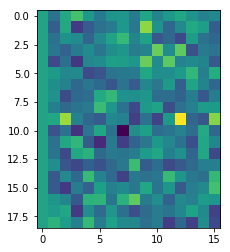

In [45]:
# Initialize empty x
X = np.zeros((n,p))

# First column is intercept
X[:,0] = 1

# Rest of the columns we will make random noise 
X[:,1:] = np.random.randn(n*(p-1)).reshape((n,(p-1)))

# Image of the last 20 rows of X
imshow(X[-20:-1,:])


#### Random Effects matrix (Z)

For simplicity, in this example $Z$ is the same for all voxels. 

[11  5]
[5 3]


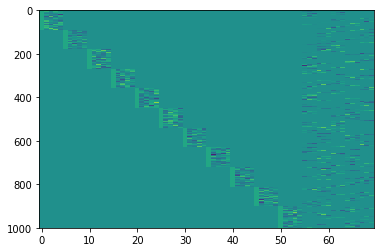

In [46]:
import sparse
# We need to create a block of Z for each level of each factor
for i in np.arange(r):
  
  Zdata_factor = np.random.randn(n,nparams[i])
  
  if i==0:
    
    #The first factor should be block diagonal, so the factor indices are grouped
    factorVec = np.repeat(np.arange(nlevels[i]), repeats=np.floor(n/max(nlevels[i],1)))
    
    if len(factorVec) < n:
      
      # Quick fix incase rounding leaves empty columns
      factorVecTmp = np.zeros(n)
      factorVecTmp[0:len(factorVec)] = factorVec
      factorVecTmp[len(factorVec):n] = nlevels[i]-1
      factorVec = np.int64(factorVecTmp)
      
    
    # Crop the factor vector - otherwise have a few too many
    factorVec = factorVec[0:n]
    
    # Give the data an intercept
    Zdata_factor[:,0]=1
    
  else:
    
    # The factor is randomly arranged across subjects
    factorVec = np.random.randint(0,nlevels[i],size=n) 
  
  # Build a matrix showing where the elements of Z should be
  indicatorMatrix_factor = np.zeros((n,nlevels[i]))
  indicatorMatrix_factor[np.arange(n),factorVec] = 1
  
  # Need to repeat for each parameter the factor has 
  indicatorMatrix_factor = np.repeat(indicatorMatrix_factor, nparams[i], axis=1)
  
  # Enter the Z values
  indicatorMatrix_factor[indicatorMatrix_factor==1]=Zdata_factor.reshape(Zdata_factor.shape[0]*Zdata_factor.shape[1])
  
  # Make sparse
  Zfactor = scipy.sparse.csr_matrix(indicatorMatrix_factor)

  # Put all the factors together
  if i == 0:
    Z = Zfactor
  else:
    Z = scipy.sparse.hstack((Z, Zfactor))


Z2 = sparse.COO.from_scipy_sparse(Z)

# Create an image of Z
imshow(Z.toarray(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

print(nlevels)
print(nparams)


#### Smooth random beta
Smooth random beta image.

0.022425413131713867


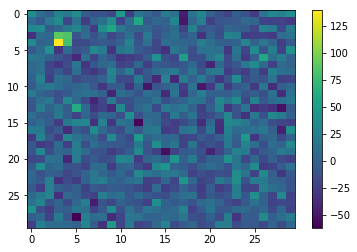

In [47]:
# Random 4D matrix (unsmoothed)
beta_us = np.random.randn(nv*p).reshape(dimv[0],dimv[1],dimv[2],p)*20
beta_us[3:5,3:5,3:5,3] = beta_us[3:5,3:5,3:5,3] + 100

t1 = time.time()
# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
beta_us_nii = nib.Nifti1Image(beta_us, affine)

# Smoothed beta nifti
beta_s_nii = nilearn.image.smooth_img(beta_us_nii, 5)

# Final beta
beta = beta_s_nii.get_fdata()

t2 = time.time()
print(t2-t1)

# Show unsmoothed
imshow(beta_us[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

plt.colorbar()

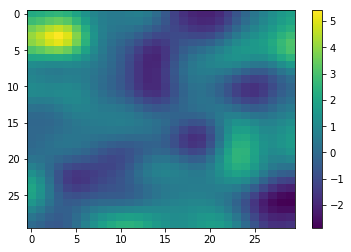

In [48]:
# Show smoothed
imshow(beta[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

#### Smooth random b
Smooth random b image.

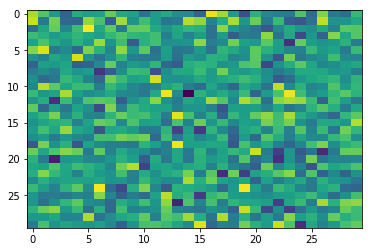

In [49]:
# Random 4D matrix (unsmoothed)
b_us = np.random.randn(nv*q).reshape(dimv[0],dimv[1],dimv[2],q)*20

# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
b_us_nii = nib.Nifti1Image(b_us, affine)

# Smoothed beta nifti
b_s_nii = nilearn.image.smooth_img(b_us_nii, 5)

# Final beta
b = b_s_nii.get_fdata()

# Show unsmoothed
imshow(b_us[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

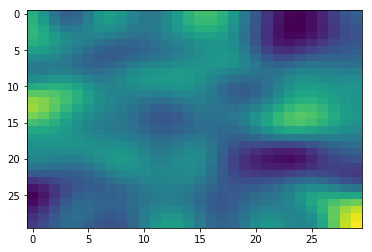

In [50]:
# Show smoothed
imshow(b[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

 #### Y vector (New response)
 
Generate response for the whole field.

In [51]:

# Reshape X
X = X.reshape(1, X.shape[0], X.shape[1])

# Reshape beta
beta = beta.reshape(beta.shape[0]*beta.shape[1]*beta.shape[2],beta.shape[3],1)
beta_True = beta

# Reshape Z (note: This step is slow because of the sparse to dense conversion;
# it could probably be made quicker but this is only for one simulation at current)
Ztmp = Z.toarray().reshape(1, Z.shape[0], Z.shape[1])

# Reshape b
b = b.reshape(b.shape[0]*b.shape[1]*b.shape[2],b.shape[3],1)

print(X.shape)
print(Ztmp.shape)
print(beta.shape)
print(b.shape)

# Generate Y
Y = np.matmul(X,beta)+np.matmul(Ztmp,b) + np.random.randn(n,1)

(1, 1000, 16)
(1, 1000, 70)
(27000, 16, 1)
(27000, 70, 1)


Check Y looks reasonable.

(27000, 1000, 1)


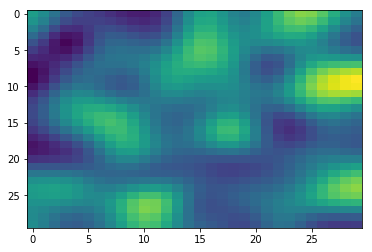

In [52]:
print(Y.shape)

Y_imageformat = Y.reshape((dimv[0],dimv[1],dimv[2],n))

imshow(Y_imageformat[3,:,:,1].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')

#### Transpose products

Calculate X'Y, X'Z, X'Y, Y'Y, Y'Z, Y'X Z'Z, Z'X and Z'Y.

In [53]:
# X'Z\Z'X
XtZ = np.matmul(X.transpose(0,2,1),Ztmp)
ZtX = XtZ.transpose(0,2,1)

# Z'Y\Y'Z
YtZ = np.matmul(Y.transpose(0,2,1),Ztmp)
ZtY = YtZ.transpose(0,2,1)

# Y'X/X'Y
YtX = np.matmul(Y.transpose(0,2,1),X)
XtY = YtX.transpose(0,2,1)

# YtY
YtY = np.matmul(Y.transpose(0,2,1),Y)

# ZtZ
ZtZ = np.matmul(Ztmp.transpose(0,2,1),Ztmp)

# X'X
XtX = np.matmul(X.transpose(0,2,1),X)


print(XtZ.shape)
print(ZtX.shape)

print(XtY.shape)
print(YtX.shape)

print(YtZ.shape)
print(ZtY.shape)

print(XtX.shape)

print(YtY.shape)

print(ZtZ.shape)

(1, 16, 70)
(1, 70, 16)
(27000, 16, 1)
(27000, 1, 16)
(27000, 1, 70)
(27000, 70, 1)
(1, 16, 16)
(27000, 1, 1)
(1, 70, 70)


### Demonstration: Time taken just looping

This is a demonstration showing how long PLS takes when doing each voxel seperately.

In [54]:
# Initialize empty estimates
beta_est = np.zeros(beta.shape)
print(beta.shape)

demo = False
if demo:
  
  # Initialize temporary X'X, X'Z, Z'X and Z'Z
  XtZtmp = XtZ[0,:,:]
  ZtXtmp = ZtX[0,:,:]
  ZtZtmp = ZtZ[0,:,:]
  XtXtmp = XtX[0,:,:]

  print(type(ZtZ))

  t1 = time.time()
  for i in np.arange(beta.shape[0]):

    print(i)

    XtYtmp = XtY[i,:,:]
    ZtYtmp = ZtY[i,:,:] 
    YtYtmp = YtY[i,:,:] 
    YtZtmp = YtZ[i,:,:]
    YtXtmp = YtX[i,:,:]

    param_est,bvals = FS(XtXtmp, XtYtmp, ZtXtmp, ZtYtmp, ZtZtmp, XtZtmp, YtZtmp, YtYtmp, YtXtmp, nlevels, nparams, 1e-6, n)

    # Get current beta
    beta_est[i,:,:] = param_est[0:beta.shape[1]]

  t2 = time.time()
  print("Time taken in seconds for this example:")
  print(t2-t1)
  print("Estimated time taken for this example on a nifti of size (100x100x100), in hours:")
  print(100*100*100*(t2-t1)/(nv*60*60))

(27000, 16, 1)


True beta (3)


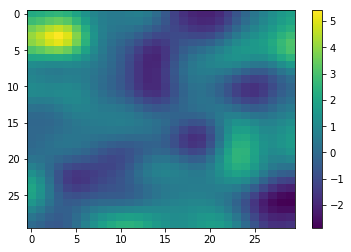

In [55]:
print("True beta (3)")
beta_map=beta.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])
beta_est_map=beta_est.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

Estimated beta (3)


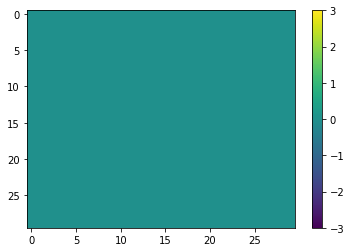

In [56]:
print("Estimated beta (3)")

# Show estimated beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), vmin=-3, vmax=3, \
                    interpolation='nearest', aspect='auto')
plt.colorbar()


**Note:** Result is roughly similar... but lots of local minima disrupting the image.

### Scaled up Helper Functions

This section contains the Nifti-equivalent functions to those given *helper functions* for an individual voxel.

#### Initial beta (broadcasted)

The below function returns the OLS estimator for several voxels at once, where the OLS estimator for a given voxel, $\hat{\beta}$, is given by:

$$\hat{\beta}_{OLS}=(X'X)^{-1}X'Y$$

----

This function takes the following inputs:

----

 - `XtX`: The design matrices transposed and multiplied by themselves ($X'X$ in the above notation)
 - `XtY`: The design matrices transposed and multiplied by the response vectors ($X'Y$ in the above notation).
 
----

It returns as outputs:

----

- `beta`: The OLS estimates of $\beta$ ($\hat{\beta}_{OLS}$ in the above notation).



In [57]:
def initBeta_broadcasted(XtX, XtY):
  
  # Get the beta estimator
  beta = np.linalg.solve(XtX,XtY)
  
  # Return the result
  return(beta)

print(initBeta(XtX,XtY))
print(np.linalg.inv(XtX) @ XtY)

[[[ 4.91795182]
  [-0.25607615]
  [ 2.77596286]
  ...
  [-3.36219379]
  [-2.96547974]
  [ 3.39332544]]

 [[ 3.71803234]
  [-0.01798858]
  [ 3.00100956]
  ...
  [-3.31809963]
  [-2.18706795]
  [ 3.21701699]]

 [[ 1.96631735]
  [ 0.22556045]
  [ 3.19126916]
  ...
  [-3.05289266]
  [-0.85186301]
  [ 2.8118537 ]]

 ...

 [[ 1.94796995]
  [-1.38674741]
  [-3.51578693]
  ...
  [ 2.39875941]
  [-3.81006659]
  [ 3.97951269]]

 [[ 2.51012841]
  [-2.43568087]
  [-3.70279756]
  ...
  [ 2.18015105]
  [-4.09124499]
  [ 2.97008268]]

 [[ 2.88400237]
  [-2.99876638]
  [-3.81711186]
  ...
  [ 1.84491224]
  [-4.24256379]
  [ 2.2645892 ]]]
[[[ 4.91795182]
  [-0.25607615]
  [ 2.77596286]
  ...
  [-3.36219379]
  [-2.96547974]
  [ 3.39332544]]

 [[ 3.71803234]
  [-0.01798858]
  [ 3.00100956]
  ...
  [-3.31809963]
  [-2.18706795]
  [ 3.21701699]]

 [[ 1.96631735]
  [ 0.22556045]
  [ 3.19126916]
  ...
  [-3.05289266]
  [-0.85186301]
  [ 2.8118537 ]]

 ...

 [[ 1.94796995]
  [-1.38674741]
  [-3.51578693]
  ..

### Sum of square residuals (broadcasted)

The function below calculates the sum of the square residuals, $e^Te$, using the below formula:

$$e^Te = (Y-X\beta)^T(Y-X\beta)$$ 
$$=Y^TY - 2Y^TX\beta + \beta^T X^TX \beta$$


----

This function takes the following inputs:

----

 - `YtX`: $Y$ transpose multiplied by $X$ ($Y^TX$ in the above notation).
 - `YtY`: $Y$ transpose multiplied by $Y$ ($Y^TY$ in the above notation).
 - `XtX`: $X$ transpose multiplied by $X$ ($X^TX$ in the above notation).
 - `beta`: An estimate of the parameter vector ($\beta$ in the above notation).
 
----

It returns as outputs:

----


 - `ete`: The sum of square residuals ($e^Te$ in the above notation).

In [58]:
def ssr_broadcasted(YtX, YtY, XtX, beta):
  
  # Return the sum of squared residuals
  return(YtY - 2*YtX @ beta + beta.transpose((0,2,1)) @ XtX @ beta)

print(ssr_broadcasted(YtX,YtY,XtX,initBeta(XtX,XtY)))

[[[56534.75774914]]

 [[44888.06370721]]

 [[32890.74970878]]

 ...

 [[34124.31298716]]

 [[47911.54109047]]

 [[60290.02204439]]]


#### Initial Sigma (Broadcasted)

The function below returns an initial estimate for the Fixed Effects Variance, $\sigma^2$. The estimator used is based on the suggested OLS estimator in Demidenko (2012) and is given by:

$$\hat{\sigma}^2_{OLS}=\frac{1}{n}(Y-X\beta)^T(Y-X\beta)$$
$$=\frac{1}{n}e^Te$$

----

This function takes the following inputs:

----

 - `ete`: The sum of square residuals ($e^Te$ in the above notation).
 - `n`: The total number of observations ($n$ in the above notation).
 
----

It returns as outputs:

----

- `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).

In [59]:
def initSigma2_broadcasted(ete, n):

  # Return the OLS estimate of sigma
  return(1/n*ete[:,0,0])

print(initSigma2_broadcasted(ssr_broadcasted(YtX,YtY,XtX,initBeta(XtX,XtY)),n))

[56.53475775 44.88806371 32.89074971 ... 34.12431299 47.91154109
 60.29002204]


### Kron (broadcasted)

Taken from https://stackoverflow.com/questions/57259557/kronecker-product-of-matrix-array

In [0]:
def kron_broadcasted(A,B):
  i,j,k = A.shape
  i,l,m = B.shape
  return(np.einsum("ijk,ilm->ijlkm",A,B).reshape(i,j*l,k*m))

#### Matrix to Vector (broadcasted)

This function takes in a stack of matrices and returns the corresponding vectorized forms of those matrices.

In [61]:
def mat2vec_broadcasted(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose(0,2,1).reshape(matrix.shape[0],matrix.shape[1]*matrix.shape[2],1))

# Example:
matrix = np.random.randn(4,3,3)
print(matrix)
print(mat2vec_broadcasted(matrix))

[[[ 1.54154642  0.55444553  0.01323832]
  [ 0.6083838   0.99857481  0.75309664]
  [ 1.9640216  -1.82181275  0.70789548]]

 [[-1.2714879  -0.30505595 -0.8450612 ]
  [ 2.18875803  0.70191168 -1.38517448]
  [-0.37531452  0.97008818 -0.85685369]]

 [[-1.83613454 -0.74693756  0.54683516]
  [-0.02560497 -0.52978332 -0.13097986]
  [-1.72285502  0.21697901  2.33511694]]

 [[-0.72449532  1.97059396  0.34013728]
  [ 1.66597969  2.55326419  0.3588915 ]
  [ 1.32161462  1.9372769  -0.42979633]]]
[[[ 1.54154642]
  [ 0.6083838 ]
  [ 1.9640216 ]
  [ 0.55444553]
  [ 0.99857481]
  [-1.82181275]
  [ 0.01323832]
  [ 0.75309664]
  [ 0.70789548]]

 [[-1.2714879 ]
  [ 2.18875803]
  [-0.37531452]
  [-0.30505595]
  [ 0.70191168]
  [ 0.97008818]
  [-0.8450612 ]
  [-1.38517448]
  [-0.85685369]]

 [[-1.83613454]
  [-0.02560497]
  [-1.72285502]
  [-0.74693756]
  [-0.52978332]
  [ 0.21697901]
  [ 0.54683516]
  [-0.13097986]
  [ 2.33511694]]

 [[-0.72449532]
  [ 1.66597969]
  [ 1.32161462]
  [ 1.97059396]
  [ 2.5532

#### Vector to matrix (broadcasted)

This function takes in a stack of vectors and returns the corresponding matrix forms of those vectors.

In [62]:
def vec2mat_broadcasted(vec):
  
  # Return matrix
  return(vec.reshape(vec.shape[0], np.int64(np.sqrt(vec.shape[1])),np.int64(np.sqrt(vec.shape[1]))).transpose(0,2,1))

# Example
vec = np.random.randn(4,4,1)
mat = vec2mat_broadcasted(vec)
print(vec)
print(mat)

[[[ 0.00950134]
  [-0.39246823]
  [ 0.64527246]
  [-0.67533304]]

 [[-0.68394147]
  [-0.21642699]
  [ 0.09936041]
  [ 0.13129012]]

 [[ 0.23868394]
  [ 0.21281357]
  [-1.7283013 ]
  [-0.65900032]]

 [[-1.26149455]
  [ 1.49131841]
  [-0.77136993]
  [-0.69883302]]]
[[[ 0.00950134  0.64527246]
  [-0.39246823 -0.67533304]]

 [[-0.68394147  0.09936041]
  [-0.21642699  0.13129012]]

 [[ 0.23868394 -1.7283013 ]
  [ 0.21281357 -0.65900032]]

 [[-1.26149455 -0.77136993]
  [ 1.49131841 -0.69883302]]]


#### Matrix to half vector (broadcasted)

This function takes in a stack of matrices and returns the corresponding vector forms of the lower halves of those matrices.

In [0]:
def mat2vech_broadcasted(matrix):
  
  # Number of voxels, nv
  nv = matrix.shape[0]
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[1]) 
  
  # Number of covariance parameters, nc
  nc = len(rowinds)
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[1]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(matrix[:,rowinds[perm],colinds[perm]].reshape((nv,nc,1)))

#### Half vector to matrix (broadcasted)

This function takes in a stack of vectors and returns the corresponding matrix forms treating the elements of the vectors as the elements of lower halves of those matrices.

In [0]:
def vech2mat_broadcasted(vech):
  
  # Number of voxels
  nv = vech.shape[0]
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[1]))/2)
  matrix = np.zeros((nv,n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(n)
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*n+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[:,rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0],vech.shape[1])
  
  # Assign values to upper half
  matrix[:,colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0],vech.shape[1])
  
  # Return vectorised half-matrix
  return(matrix)


#### Initial D_k (broadcasted)

The function below returns an initial estimate for the Random Effects Variance matrix for the $k^{th}$ grouping factor, $D_k$. The estimator used is an adaption of the suggested estimator in Demidenko (2012) and is given by:

$$vec(\hat{D}_{k})=\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)$$

Or:

$$\hat{D}_{k}=matrix\bigg(\bigg[\sum_{j=1}^{l_k}(Z_{(k,j)}^TZ_{(k,j)}) \otimes (Z_{(k,j)}^TZ_{(k,j)})\bigg]^{-1}vec\bigg(\sum_{j=1}^{l_k}[\hat{\sigma}^{-2}_{OLS}Z_{(k,j)}^Tee^TZ_{(k,j)} - Z_{(k,j)}^TZ_{(k,j)}]\bigg)\bigg)$$

----

This function takes the following inputs:

----

 - `k`: The grouping factor we wish to estimate $D$ for ($k$ in the above notation)
 - `lk`: The number of levels belonging to grouping factor $k$ ($l_k$ in the above notation).
 - `ZtZ`: The $Z$ matrix transposed and then multiplied by itself ($Z^TZ$ in the above notation).
 - `Zte`: The $Z$ matrix transposed and then multiplied by the OLS residuals ($Z^Te=Z^T(Y-X\beta)$ in the above notation).
 - `sigma2`: The OLS estimate of $\sigma^2$ ($\hat{\sigma}^2_{OLS}$ in the above notation).
 
----

It returns as outputs:

----

- `Dkest`: The inital estimate of $D_k$ ($\hat{D}_k$ in the above notation).


###CHECK DERIVATION

In [65]:
def initDk_broadcasted(k, lk, ZtZ, Zte, sigma2):
  
  # Initalize D to zeros
  invSig2ZteetZminusZtZ = np.zeros((Zte.shape[0],nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out Z_(k, j)'Z_(k, j)
    ZkjtZkj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)]
    
    # Work out Z_(k,j)'e
    Zkjte = Zte[:, Ikj,:]
    
    if j==0:
      
      # Add first Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = kron_broadcasted(ZkjtZkj,ZkjtZkj.transpose(0,2,1))
      
      # Add first \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = np.einsum('i,ijk->ijk',1/sigma2,(Zkjte @ Zkjte.transpose(0,2,1))) - ZkjtZkj
      
    else:
      
      # Add next Z_(k,j)'Z_(k,j) kron Z_(k,j)'Z_(k,j)
      ZtZkronZtZ = ZtZkronZtZ + kron_broadcasted(ZkjtZkj,ZkjtZkj.transpose(0,2,1))
      
      # Add next \sigma^{-2}Z'ee'Z - Z_(k,j)'Z_(k,j)
      invSig2ZteetZminusZtZ = invSig2ZteetZminusZtZ + np.einsum('i,ijk->ijk',1/sigma2,(Zkjte @ Zkjte.transpose(0,2,1))) - ZkjtZkj
      
  # Work out the final term.
  Dkest = vec2mat_broadcasted(np.linalg.inv(ZtZkronZtZ) @ mat2vec_broadcasted(invSig2ZteetZminusZtZ)) 
  
  
  return(Dkest)

Zte = ZtY-ZtX @ np.random.randn(ZtY.shape[0],ZtX.shape[2],1)

t1 = time.time()
initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))
t2 = time.time()

print(t2-t1)

t1 = time.time()
initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))
t2 = time.time()

print(t2-t1)

print(initDk_broadcasted(0, nlevels[0], ZtZ, Zte , np.ones(Zte.shape[0]))[8,:,:])

t1 = time.time()
print(initDk(0, nlevels[0], ZtZ[0,:,:], Zte[8,:,:], 1))
t2 = time.time()

print(t2-t1)

0.41564035415649414
0.1696946620941162
[[ 5.36384127 -0.64222882 -3.34108776 -0.38947429 -0.39417497]
 [-0.64222882  4.12494155 -0.05795925 -1.36253347  0.40706079]
 [-3.34108776 -0.05795925  5.35791004  0.57703582 -2.33859488]
 [-0.38947429 -1.36253347  0.57703582  1.35720552 -0.35707717]
 [-0.39417497  0.40706079 -2.33859488 -0.35707717  5.31388962]]
[[ 5.36384127 -0.64222882 -3.34108776 -0.38947429 -0.39417497]
 [-0.64222882  4.12494155 -0.05795925 -1.36253347  0.40706079]
 [-3.34108776 -0.05795925  5.35791004  0.57703582 -2.33859488]
 [-0.38947429 -1.36253347  0.57703582  1.35720552 -0.35707717]
 [-0.39417497  0.40706079 -2.33859488 -0.35707717  5.31388962]]
0.0030145645141601562


#### Make D non-negative definite (Broadcasted)

This function projects a stack of matrices into the space of non-negative definite matrices.

In [66]:
def makeDnnd_broadcasted(D):
  
  # Check if we have negative eigenvalues
  if not np.all(np.linalg.eigvals(D)>0):
  
    # If we have negative eigenvalues
    eigvals,eigvecs = np.linalg.eigh(D)
    
    # Work out elementwise max of lambda and 0
    lamplus = np.zeros((eigvals.shape[0], eigvals.shape[1], eigvals.shape[1]))
    diag = np.arange(eigvals.shape[1])
    lamplus[:, diag, diag] = np.maximum(eigvals,0)
    
    # Work out D+
    D_nnd = eigvecs @ lamplus @ np.linalg.inv(eigvecs)
    
  else:
    
    # D is already non-negative in this case
    D_nnd = D
    
  return(D_nnd)
  
D = np.random.randn(100000,3,3)
t1 = time.time()
print(makeDnnd_broadcasted(D)[10,:,:])
t2 = time.time()
print(t2-t1)
t1 = time.time()
print(makeDnnd(D[10,:,:]))
t2 = time.time()
print(t2-t1)


### COULD BE IMPROVED SPEED WISE

[[ 0.05000751  0.06102691 -0.07996357]
 [ 0.06102691  0.07447449 -0.09758393]
 [-0.07996357 -0.09758393  0.12786422]]
1.0307631492614746
[[ 0.05000751  0.06102691 -0.07996357]
 [ 0.06102691  0.07447449 -0.09758393]
 [-0.07996357 -0.09758393  0.12786422]]
0.001069784164428711


### Get D from dict (broadcasted)

This function takes in a dictionary, `Ddict`, in which entry `k` is a stack of the $k^{th}$ diagonal block for every voxel.

In [67]:
def getDfromDict_broadcasted(Ddict, nparams, nlevels):
  
  # Get number of voxels
  nv = Ddict[0].shape[0]
  
  # Work out indices (there is one block of D per level)
  inds = np.zeros(np.sum(nlevels)+1)
  counter = 0
  for k in np.arange(len(nparams)):
    for j in np.arange(nlevels[k]):
      inds[counter] = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
      counter = counter + 1
      
  
  # Last index will be missing so add it
  inds[len(inds)-1]=inds[len(inds)-2]+nparams[-1]
  
  # Make sure indices are ints
  inds = np.int64(inds)
  
  # Initial D
  D = np.zeros((nv,np.sum(nparams*nlevels),np.sum(nparams*nlevels)))

  counter = 0
  for k in np.arange(len(nparams)):
    for j in np.arange(nlevels[k]):

      D[:, inds[counter]:inds[counter+1], inds[counter]:inds[counter+1]] = Ddict[k]
      counter = counter + 1
  
  return(D)
  
# Example dict
nparams_tmp = np.array([10,2,3])
nlevels_tmp = np.array([30,22,4])

Ddict_tmp = dict()
for i in np.arange(len(nparams_tmp)):
  
  Ddict_tmp[i] = np.random.randn(2000,nparams_tmp[i],nparams_tmp[i])

t1 = time.time()
D = getDfromDict_broadcasted(Ddict_tmp, nparams_tmp, nlevels_tmp)
t2 = time.time()
print(t2-t1)

3.0461831092834473


#### Force Symmetric (Broadcasted)

This function forces a stack of matrices to be symmetric.

In [68]:
# Developer NOTE: DO NOT USE NUMBA ON THIS FUNCTION - NUMBA BUGGERS IT UP FOR UNKNOWN REASONS
def forceSym_broadcasted(x):
  
  # Force it to be symmetric
  return((x+x.transpose((0,2,1)))/2)

  
print(ZtZ.shape)
t1 = time.time()
ZtZ = forceSym_broadcasted(forceSym_broadcasted(ZtZ))
print(time.time()-t1)

print(ZtZ.shape)
t1 = time.time()
ZtZ = forceSym_broadcasted(forceSym_broadcasted(ZtZ))
print(time.time()-t1)

(1, 70, 70)
0.00017309188842773438
(1, 70, 70)
0.00013685226440429688


#### Derivative of $\frac{\delta l}{\delta \beta}$ (broadcasted)

This function returns the derivative of $l$ with respect to $\beta$ for all voxels.

In [0]:
def get_dldB_broadcasted(sigma2, Xte, XtZ, DinvIplusZtZD, Zte):
  
  # Work out the derivative (Note: we leave everything as 3D for ease of future computation)
  deriv = np.einsum('i,ijk->ijk',1/sigma2, (Xte - (XtZ @ DinvIplusZtZD @ Zte)))
                    
  # Return the derivative
  return(deriv)

#### Derivative of $\frac{\delta l}{\delta \sigma^2}$ (broadcasted)

This function returns the derivative of $l$ with respect to $\sigma^2$ for all voxels.

In [0]:
def get_dldsigma2_broadcasted(n, ete, Zte, sigma2, DinvIplusZtZD):
  
  # Get e'(I+ZDZ')^(-1)e=e'e-e'ZD(I+Z'ZD)^(-1)Z'e
  etinvIplusZtDZe = ete - forceSym_broadcasted(Zte.transpose((0,2,1)) @ DinvIplusZtZD @ Zte)
  
  # Get the derivative
  deriv = -n/(2*sigma2) + np.einsum('i,ijk->ijk',1/(2*(sigma2**2)), etinvIplusZtDZe).reshape(sigma2.shape[0])
  
  return(deriv)

#### Derivative of $\frac{\delta l}{\delta D_k}$ (broadcasted)

This function returns the derivative of $l$ with respect to $D_k$ for all voxels.

In [0]:
def get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD):

  # Number of voxels
  nv = Zte.shape[0]
  
  # Initalize the derivative to zeros
  dldDk = np.zeros((nv, nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)
    
    # Get (the kj^th columns of Z)^T multiplied by Z
    Z_kjtZ = ZtZ[:,Ikj,:]
    Z_kjte = Zte[:,Ikj,:]
    
    # Get the first term of the derivative
    Z_kjtVinve = Z_kjte - (Z_kjtZ @ DinvIplusZtZD @ Zte)
    firstterm = np.einsum('i,ijk->ijk',1/sigma2,forceSym_broadcasted(Z_kjtVinve @ Z_kjtVinve.transpose((0,2,1))))
    
    # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
    Z_kjtZ_kj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)]
    secondterm = forceSym_broadcasted(Z_kjtZ_kj) - forceSym_broadcasted(Z_kjtZ @ DinvIplusZtZD @ Z_kjtZ.transpose((0,2,1)))
    
    if j == 0:
      
      # Start a running sum over j
      dldDk = firstterm - secondterm
      
    else:
    
      # Add these to the running sum
      dldDk = dldDk + firstterm - secondterm
    
  # Halve the sum (the coefficient of a half was not included in the above)
  dldDk = forceSym_broadcasted(dldDk/2)

  # Store it in the dictionary
  return(dldDk)

#### Covariance of derivative of $\frac{\delta l}{\delta \beta}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $\beta$ for all voxels.

In [0]:
def get_covdldbeta_broadcasted(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2):
  
  # Get the covariance of the derivative
  covderiv = np.einsum('i,ijk->ijk',1/sigma2,(XtX - forceSym_broadcasted(XtZ @ DinvIplusZtZD @ XtZ.transpose((0,2,1)))))
  
  # Return the covariance of the derivative
  return(covderiv)

#### Covariance of derivative of $\frac{\delta l}{\delta \sigma^2}$ and $\frac{\delta l}{\delta D_k}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $\sigma^2$ and $D_k$ for all voxels.

In [0]:
def get_covdldDkdsigma2_broadcasted(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Number of voxels
  nv = DinvIplusZtZD.shape[0]
  
  # Sum of R_(k, j) over j
  RkSum = np.zeros((nv,nparams[k],nparams[k]))

  for j in np.arange(nlevels[k]):

    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)

    # Work out R_(k, j)
    Rkj = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ikj,Ikj)] - forceSym_broadcasted(ZtZ[:,Ikj,:] @ DinvIplusZtZD @ ZtZ[:,:,Ikj])
    
    # Add together
    RkSum = RkSum + Rkj

  # Multiply by duplication matrices and save
  covdldDdldsigma2 = np.einsum('i,ijk->ijk', 1/(2*sigma2), invDupMatdict[k] @ mat2vec_broadcasted(RkSum))
  
  return(covdldDdldsigma2)

#### Covariance of derivative of $\frac{\delta l}{\delta D_{k_1}}$ and $\frac{\delta l}{\delta D_{k_2}}$ (broadcasted)

This function returns the covariance of the derivative of $l$ with respect to $D_{k_1}$ and $D_{k_2}$ for all voxels.

In [0]:
def get_covdldDk1Dk2_broadcasted(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict):
  
  # Sum of R_(k1, k2, i, j) kron R_(k1, k2, i, j) over i and j 
  for i in np.arange(nlevels[k1]):

    for j in np.arange(nlevels[k2]):
      
      # Get the indices for the k1th factor jth level
      Ik1i = faclev_indices(k1, i, nlevels, nparams)
      Ik2j = faclev_indices(k2, j, nlevels, nparams)
      
      # Work out R_(k1, k2, i, j)
      Rk1k2ij = ZtZ[np.ix_(np.arange(ZtZ.shape[0]),Ik1i,Ik2j)] - (ZtZ[:,Ik1i,:] @ DinvIplusZtZD @ ZtZ[:,:,Ik2j])
      
      # Work out Rk1k2ij kron Rk1k2ij
      RkRt = kron_broadcasted(Rk1k2ij,Rk1k2ij)
      
      # Add together
      if (i == 0) and (j == 0):
      
        RkRtSum = RkRt
      
      else:
        
        RkRtSum = RkRtSum + RkRt
    
  # Multiply by duplication matrices and save
  covdldDk1dldk2 = 1/2 * invDupMatdict[k1] @ RkRtSum @ invDupMatdict[k2].transpose()
  
  # Return the result
  return(covdldDk1dldk2)


#### Log likelihood (broadcasted)

This function returns the loglikelihood for all voxels.

In [0]:
def llh_broadcasted(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D):
  
  # Work out -1/2(nln(sigma^2) + ln|I+Z'ZD|)
  firstterm = -0.5*(n*np.log(sigma2) + np.log(np.linalg.det(np.eye(ZtZ.shape[1]) + ZtZ @ D)))
                    
  # Work out sigma^(-2)*(e'e - e'ZD(I+Z'ZD)^(-1)Z'e)
  secondterm = -0.5*np.einsum('i,ijk->ijk',(1/sigma2),(ete - forceSym_broadcasted(Zte.transpose((0,2,1)) @ DinvIplusZtZD @ Zte)))
  
  # Work out the log likelihood
  llh = firstterm + secondterm
  
  # Return result
  return(llh)


### Broadcasted FS

The below function performs FS for a NIFTI.

In [76]:
def FS_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, tol,n):
  
  #-------------------------------------------------------------------------------
  # Testing - one voxel
  
  # one voxel index
  ovi = 10
  
  XtX_ov = XtX[0,:,:] 
  XtY_ov = XtY[ovi,:,:]
  ZtX_ov = ZtX[0,:,:]
  ZtY_ov = ZtY[ovi,:,:] 
  ZtZ_ov = ZtZ[0,:,:] 
  XtZ_ov = XtZ[0,:,:] 
  YtZ_ov = YtZ[ovi,:,:] 
  YtY_ov = YtY[ovi,:,:] 
  YtX_ov = YtX[ovi,:,:]
  
  
  t1_total = time.time()
  t1 = time.time()
  
  # Useful scalars
  # ------------------------------------------------------------------------------

  # Number of factors, r
  r = len(nlevels)

  # Number of random effects, q
  q = np.sum(np.dot(nparams,nlevels))

  # Number of fixed effects, p
  p = XtX.shape[1]

  # Number of voxels, nv
  nv = XtY.shape[0]
  
  # Initial estimates
  # ------------------------------------------------------------------------------

  # Inital beta
  beta = initBeta_broadcasted(XtX, XtY)
  beta_ov = initBeta(XtX_ov, XtY_ov)
  #print('beta', beta[10,:,:], beta_ov)
  
  # Work out e'e
  ete = ssr_broadcasted(YtX, YtY, XtX, beta)
  ete_ov = ssr(YtX_ov, YtY_ov, XtX_ov, beta_ov)
  #print('ete', ete[10], ete_ov)
  
  # Initial sigma2
  sigma2 = initSigma2_broadcasted(ete, n)
  sigma2_ov = initSigma2(ete_ov, n)
  #print('sigma2', sigma2[10], sigma2_ov)

  Zte = ZtY - (ZtX @ beta) 
  Zte_ov = ZtY_ov - (ZtX_ov @ beta_ov) 

  # Inital D
  # Dictionary version
  Ddict = dict()
  for k in np.arange(len(nparams)):

    Ddict[k] = makeDnnd_broadcasted(initDk_broadcasted(k, nlevels[k], ZtZ, Zte, sigma2))
  
  Ddict_ov = dict()
  for k in np.arange(len(nparams)):

    Ddict_ov[k] = makeDnnd(initDk(k, nlevels[k], ZtZ_ov, Zte_ov, sigma2_ov))
    #print('D' + str(k), Ddict[k][10,:,:], Ddict_ov[k])
  
  # Full version of D
  D = getDfromDict_broadcasted(Ddict, nparams, nlevels)
    
  # Matrix version
  D_ov = np.array([])
  for i in np.arange(len(nparams)):

    for j in np.arange(nlevels[i]):

      if i == 0 and j == 0:

        D_ov = Ddict_ov[i]

      else:

        D_ov = scipy.linalg.block_diag(D_ov, Ddict_ov[i])
  
  #print('D', D[10,:,:], D_ov)
  
  # Duplication matrices
  # ------------------------------------------------------------------------------
  invDupMatdict = dict()
  for i in np.arange(len(nparams)):

    invDupMatdict[i] = np.asarray(invDupMat(nparams[i]).todense())
    
    #print('invDupMat ' + str(i), invDupMatdict[i])
  
  # Index variables
  # ------------------------------------------------------------------------------
  # Work out the total number of paramateres
  tnp = np.int32(p + 1 + np.sum(nparams*(nparams+1)/2))

  # Indices for submatrics corresponding to Dks
  FishIndsDk = np.int32(np.cumsum(nparams*(nparams+1)/2) + p + 1)
  FishIndsDk = np.insert(FishIndsDk,0,p+1)

  Zte = ZtY - (ZtX @ beta)
  Zte_ov = ZtY_ov - (ZtX_ov @ beta_ov)
  
  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD = np.eye(q) + ZtZ @ D
  DinvIplusZtZD =  forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) # Currently using numpy... might be able to improve on this inversion
  
  
  # Inverse of (I+Z'ZD) multiplied by D
  IplusZtZD_ov = np.eye(q) + ZtZ_ov @ D_ov
  DinvIplusZtZD_ov = forceSym(D_ov @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD_ov)))
  
  #print('D(I + ZtZ)^(-1)', DinvIplusZtZD[10,:,:], DinvIplusZtZD_ov)

  
  # Step size lambda
  lam = np.ones(XtY.shape[0])
  lam_ov = 1

  # Initial log likelihoods
  llhprev = -10*np.ones(XtY.shape[0])
  llhcurr = 10*np.ones(XtY.shape[0])
  
  t2 = time.time()
  print('Setup time: ', t2-t1)
  
  nit=0
  examplellh=np.zeros(100)
  while np.any(np.abs(llhprev-llhcurr)>tol):
    
    t1 = time.time()
    # Change current likelihood to previous
    llhprev = llhcurr

    # Matrices needed later by many calculations:
    # ----------------------------------------------------------------------------
    # X transpose e and Z transpose e
    Xte = XtY - (XtX @ beta)
    Zte = ZtY - (ZtX @ beta)
    
    Xte_ov = XtY_ov - (XtX_ov @ beta_ov)
    Zte_ov = ZtY_ov - (ZtX_ov @ beta_ov)
    
    # Inverse of (I+Z'ZD) multiplied by D
    IplusZtZD = np.eye(q) + (ZtZ @ D)
    DinvIplusZtZD = forceSym_broadcasted(D @ np.linalg.inv(IplusZtZD)) # Currently using numpy... might be able to improve on this inversion
    
    IplusZtZD_ov = np.eye(q) + (ZtZ_ov @ D_ov)
    DinvIplusZtZD_ov = forceSym(D_ov @ scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(IplusZtZD_ov)))
    #print('D(I + ZtZ)^(-1)', DinvIplusZtZD[10,:,:], DinvIplusZtZD_ov)

    # Sum of squared residuals
    ete = ssr_broadcasted(YtX, YtY, XtX, beta)
    ete_ov = ssr(YtX_ov, YtY_ov, XtX_ov, beta_ov)
    #print('ete', ete[10,:,:], ete_ov)
    
    # Derivatives
    # ----------------------------------------------------------------------------

    # Derivative wrt beta
    dldB = get_dldB_broadcasted(sigma2, Xte, XtZ, DinvIplusZtZD, Zte)
    dldB_ov = get_dldB(sigma2_ov, Xte_ov, XtZ_ov, DinvIplusZtZD_ov, Zte_ov)
    #print('dldB', dldB[10,:,:], dldB_ov)
    
    # Derivative wrt sigma^2
    dldsigma2 = get_dldsigma2_broadcasted(n, ete, Zte, sigma2, DinvIplusZtZD) 
    dldsigma2_ov = get_dldsigma2(n, ete_ov, Zte_ov, sigma2_ov, DinvIplusZtZD_ov) 
    #print('dldsigma2', dldsigma2[10], dldsigma2_ov)
    
    # For each factor, factor k, work out dl/dD_k
    dldDdict = dict()
    for k in np.arange(len(nparams)):
      # Store it in the dictionary
      dldDdict[k] = get_dldDk_broadcasted(k, nlevels, nparams, ZtZ, Zte, sigma2, DinvIplusZtZD)

    dldDdict_ov = dict()
    for k in np.arange(len(nparams)):
      # Store it in the dictionary
      dldDdict_ov[k] = get_dldDk(k, nlevels, nparams, ZtZ_ov, Zte_ov, sigma2_ov, DinvIplusZtZD_ov)
      #print('dldDdict '+str(k),dldDdict[k][10,:,:],dldDdict_ov[k])
    
    # Covariances
    # ----------------------------------------------------------------------------

    # Construct the Fisher Information matrix
    # ----------------------------------------------------------------------------
    FisherInfoMat = np.zeros((nv,tnp,tnp))
    FisherInfoMat_ov = np.zeros((tnp,tnp))
    
    # Covariance of dl/dsigma2
    covdldsigma2 = n/(2*(sigma2**2))
    covdldsigma2_ov = n/(2*(sigma2_ov**2))
    #print('covdldsigma2', covdldsigma2[10],covdldsigma2_ov)
    
    # Add dl/dsigma2 covariance
    FisherInfoMat[:,p,p] = covdldsigma2
    FisherInfoMat_ov[p,p] = covdldsigma2_ov
    
    # Add dl/dbeta covariance
    covdldB = get_covdldbeta_broadcasted(XtZ, XtX, ZtZ, DinvIplusZtZD, sigma2)
    covdldB_ov = get_covdldbeta(XtZ_ov, XtX_ov, ZtZ_ov, DinvIplusZtZD_ov, sigma2_ov)
    #print('covdldB', covdldB[10,:,:], covdldB_ov)
    
    FisherInfoMat[np.ix_(np.arange(nv), np.arange(p),np.arange(p))] = covdldB
    FisherInfoMat_ov[np.ix_(np.arange(p),np.arange(p))] = covdldB_ov
    #print('FImat check', FisherInfoMat[10,:,:], FisherInfoMat_ov)
    
    # Add dl/dsigma2 dl/dD covariance
    for k in np.arange(len(nparams)):

      # Get covariance of dldsigma and dldD      
      covdldsigmadD = get_covdldDkdsigma2_broadcasted(k, sigma2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict).reshape(nv,FishIndsDk[k+1]-FishIndsDk[k])
      covdldsigmadD_ov =  get_covdldDkdsigma2(k, sigma2_ov, nlevels, nparams, ZtZ_ov, DinvIplusZtZD_ov, invDupMatdict).reshape(FishIndsDk[k+1]-FishIndsDk[k])
      
      #print('cov(dl/dsigma,dl/dD) ' + str(k), covdldsigmadD[10,:],covdldsigmadD_ov)
      
      # Assign to the relevant block
      FisherInfoMat[:,p, FishIndsDk[k]:FishIndsDk[k+1]] = covdldsigmadD
      FisherInfoMat[:,FishIndsDk[k]:FishIndsDk[k+1],p:(p+1)] = FisherInfoMat[:,p:(p+1), FishIndsDk[k]:FishIndsDk[k+1]].transpose((0,2,1))
    
      FisherInfoMat_ov[p, FishIndsDk[k]:FishIndsDk[k+1]] = covdldsigmadD_ov
      FisherInfoMat_ov[FishIndsDk[k]:FishIndsDk[k+1],p] = FisherInfoMat_ov[p, FishIndsDk[k]:FishIndsDk[k+1]].transpose()

      #print('Fisher Info Mat check ' + str(k), FisherInfoMat[10,:,:], FisherInfoMat_ov)
      #print(np.sum(np.sum(np.abs(FisherInfoMat[10,:,:]- FisherInfoMat_ov))))
   
    # Add dl/dD covariance
    for k1 in np.arange(len(nparams)):

      for k2 in np.arange(k1+1):

        IndsDk1 = np.arange(FishIndsDk[k1],FishIndsDk[k1+1])
        IndsDk2 = np.arange(FishIndsDk[k2],FishIndsDk[k2+1])

        # Get covariance between D_k1 and D_k2 
        covdldDk1dDk2 = get_covdldDk1Dk2_broadcasted(k1, k2, nlevels, nparams, ZtZ, DinvIplusZtZD, invDupMatdict)
        
        # Get covariance between D_k1 and D_k2 
        covdldDk1dDk2_ov = get_covdldDk1Dk2(k1, k2, nlevels, nparams, ZtZ_ov, DinvIplusZtZD_ov, invDupMatdict)
        
        #print('cov(dldDk, dldDk) ' + str(k1) + ' ' + str(k2))
        #print(covdldDk1dDk2[10,:,:])
        #print(covdldDk1dDk2_ov)
        #print(np.sum(np.sum(np.abs(covdldDk1dDk2[10,:,:]-covdldDk1dDk2_ov))))
        
        # Add to FImat
        FisherInfoMat[np.ix_(np.arange(nv), IndsDk1, IndsDk2)] = covdldDk1dDk2
        FisherInfoMat[np.ix_(np.arange(nv), IndsDk2, IndsDk1)] = FisherInfoMat[np.ix_(np.arange(nv), IndsDk1, IndsDk2)].transpose((0,2,1))
        
        # Add to FImat 
        FisherInfoMat_ov[np.ix_(IndsDk1, IndsDk2)] = covdldDk1dDk2_ov
        FisherInfoMat_ov[np.ix_(IndsDk2, IndsDk1)] = FisherInfoMat_ov[np.ix_(IndsDk1, IndsDk2)].transpose()

        #print('Fisher Info Mat check ' + str(k1) + ' ' + str(k2))
        #print(np.sum(np.sum(np.abs(FisherInfoMat[10,:,:]- FisherInfoMat_ov))))
       
    # Derivative and parameters
    # ----------------------------------------------------------------------------

    # Concatenate paramaters and derivatives together
    # ----------------------------------------------------------------------------
    paramVector = np.concatenate((beta, sigma2.reshape(nv,1,1)),axis=1)
    derivVector = np.concatenate((dldB, dldsigma2.reshape(nv,1,1)),axis=1)
    
    
    paramVector_ov = np.concatenate((beta_ov, np.array([[sigma2_ov]])))
    derivVector_ov = np.concatenate((dldB_ov, dldsigma2_ov))
    
    #print('paramvec check', np.sum(np.sum(np.abs(paramVector_ov-paramVector[10,:,:]))))
    #print('derivvec check', np.sum(np.sum(np.abs(derivVector_ov-derivVector[10,:,:]))))


    for k in np.arange(len(nparams)):

      paramVector = np.concatenate((paramVector, mat2vech_broadcasted(Ddict[k])),axis=1)
      derivVector = np.concatenate((derivVector, mat2vech_broadcasted(dldDdict[k])),axis=1)
      
      paramVector_ov = np.concatenate((paramVector_ov, mat2vech(Ddict_ov[k])))
      derivVector_ov = np.concatenate((derivVector_ov, mat2vech(dldDdict_ov[k])))
    
      #print('paramvec check', np.sum(np.sum(np.abs(paramVector_ov-paramVector[10,:,:]))))
      #print('derivvec check', np.sum(np.sum(np.abs(derivVector_ov-derivVector[10,:,:]))))
      
    
    # Update step
    # ----------------------------------------------------------------------------
    FisherInfoMat = forceSym_broadcasted(FisherInfoMat)
    paramVector = paramVector + np.einsum('i,ijk->ijk',lam,(np.linalg.inv(FisherInfoMat) @ derivVector))
    
    
    FisherInfoMat_ov = forceSym(FisherInfoMat_ov)
    paramVector_ov = paramVector_ov + lam_ov*(np.linalg.inv(FisherInfoMat_ov) @ derivVector_ov)
    
    #print('Final FI check', np.sum(np.sum(np.abs(FisherInfoMat[10,:,:]-FisherInfoMat_ov))))
    #print('Update check', np.sum(np.sum(np.abs(paramVector[10,:,:]-paramVector_ov))))

    # Get the new parameters
    beta = paramVector[:,0:p,:]
    sigma2 = paramVector[:,p:(p+1)][:,0,0]
    
    
    beta_ov = paramVector_ov[0:p]
    sigma2_ov = paramVector_ov[p:(p+1)][0,0]

    #print('beta check', np.sum(np.sum(np.abs(beta_ov - beta[10,:,:]))))
    #print('sigma2 check', np.sum(np.sum(np.abs(sigma2_ov - sigma2[10]))))
    
    # D as a dictionary
    for k in np.arange(len(nparams)):

      Ddict[k] = makeDnnd_broadcasted(vech2mat_broadcasted(paramVector[:,FishIndsDk[k]:FishIndsDk[k+1],:]))
      

    for k in np.arange(len(nparams)):

      Ddict_ov[k] = makeDnnd(vech2mat(paramVector_ov[FishIndsDk[k]:FishIndsDk[k+1]]))
      
      #print('Ddict check ' + str(k), Ddict[k][10,:,:], Ddict_ov[k])
      
      
    # Full version of D
    D = getDfromDict_broadcasted(Ddict, nparams, nlevels)
    
    for i in np.arange(len(nparams)):

      for j in np.arange(nlevels[i]):


        if i == 0 and j == 0:

          D_ov = Ddict_ov[i]

        else:

          D_ov = scipy.linalg.block_diag(D_ov, Ddict_ov[i])
    
    #print('Dcheck', np.sum(np.sum(np.abs(D[10,:,:]-D_ov))))
    
    # Update the step size
    llhcurr = llh_broadcasted(n, ZtZ, Zte, ete, sigma2, DinvIplusZtZD,D)[:,0,0]
    llhcurr_ov = llh(n, ZtZ_ov, Zte_ov, ete_ov, sigma2_ov, DinvIplusZtZD_ov,D_ov)
    #print('llh check',llhcurr[10]-llhcurr_ov)
    
    lam[llhprev>llhcurr] = lam[llhprev>llhcurr]/2
    
    examplellh[nit] = llhcurr[10]
    if nit==99:
      break
    
    print('sumlam:', np.sum(lam))

    t2 = time.time()
    nit = nit + 1
    print('Iteration num: ', nit)
    print('Iteration time: ', t2-t1)
    print('Num converged:', nv-np.sum(np.abs(llhprev-llhcurr)>tol))
    
  bvals = DinvIplusZtZD @ Zte
  
  print('Total time taken: ', time.time()-t1_total)
  print('Estimated NIFTI time (hours): ', 100*100*100/(nv*60*60)*(time.time()-t1_total))
  
  return(paramVector, bvals, examplellh)

t1 = time.time()
paramVec, bvals, examplellh = FS_broadcasted(XtX, XtY, ZtX, ZtY, ZtZ, XtZ, YtZ, YtY, YtX, nlevels, nparams, 1e-6,n)
t2 = time.time()
print(t2-t1)

print("Predicted time on nifti of size 100x100x100 (in hours): ", 100*100*100*(t2-t1)/(nv*60*60))



Setup time:  14.18008303642273
sumlam: 13500.0
Iteration num:  1
Iteration time:  124.39200711250305
Num converged: -26000
sumlam: 12679.5
Iteration num:  2
Iteration time:  126.12909817695618
Num converged: -26000
sumlam: 11423.625
Iteration num:  3
Iteration time:  125.46556496620178
Num converged: -26000


KeyboardInterrupt: ignored

In [0]:
beta_est_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
beta_est_map=paramVec[:,0:p,:].reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])
beta_True_map=beta_True.reshape(dimv[0],dimv[1],dimv[2],beta.shape[1])


# Show true beta, 3rd x-slice, 3rd parameter
imshow((beta_est_map[3,:,:,3]-beta_True_map[3,:,:,3]).reshape(dimv[0],dimv[1]), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()